In [28]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Significance Testing Methods

In [29]:
from scipy.stats import wilcoxon
import numpy as np

def dm_test(e1, e2, h=1, power=2):
    """
    Diebold-Mariano test for predictive accuracy.
    e1 and e2 are arrays of forecast errors from models A and B (e.g., MAE or squared error).
    h is the forecast horizon (1 for one-step-ahead).
    power=2 for MSE, power=1 for MAE.
    """
    e1, e2 = np.array(e1), np.array(e2)
    d = np.abs(e1) ** power - np.abs(e2) ** power  # loss differential
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    
    from scipy.stats import norm
    p_value = 2 * norm.cdf(-abs(dm_stat))
    return dm_stat, p_value

def compare_models(errors_a, errors_b, name_a='Model A', name_b='Model B'):
    errors_a = np.array(errors_a)
    errors_b = np.array(errors_b)
    diff = errors_a - errors_b

    # Wilcoxon Signed-Rank Test
    try:
        stat_wilcoxon, p_wilcoxon = wilcoxon(diff)
    except ValueError:
        stat_wilcoxon, p_wilcoxon = None, None
        print("Wilcoxon test could not be computed (possibly zero differences).")

    # Diebold-Mariano Test
    stat_dm, p_dm = dm_test(errors_a, errors_b)

    # Direction
    mean_diff = diff.mean()
    if mean_diff > 0:
        winner = name_b
    elif mean_diff < 0:
        winner = name_a
    else:
        winner = "Neither (equal performance)"

    # Print summary
    print(f"=== Model Comparison ===")
    print(f"Mean {name_a} Error: {errors_a.mean():.4f}")
    print(f"Mean {name_b} Error: {errors_b.mean():.4f}")
    print(f"Mean Difference (A - B): {mean_diff:.4f}")
    print(f"Winner: {winner}\n")

    print(f"Wilcoxon Test:     stat = {stat_wilcoxon}, p = {p_wilcoxon}")
    print(f"Diebold-Mariano:  stat = {stat_dm:.4f}, p = {p_dm:.4f}")
    
    return {
        'winner': winner,
        'wilcoxon_stat': stat_wilcoxon,
        'wilcoxon_p': p_wilcoxon,
        'dm_stat': stat_dm,
        'dm_p': p_dm
    }


In [30]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_quantiles(y_true, y_pred, q):
    return np.quantile(np.abs((y_true - y_pred) / y_true) * 100, q)

def mape_std(y_true, y_pred):
    return np.std(np.abs((y_true - y_pred) / y_true)) * 100

## Load data

In [31]:
mbstgnn =  pd.read_csv(f"../../outputs/all_test_predictions_sageconv_b_64.csv")

graph_baseline = pd.read_csv("../../outputs/all_test_predictions_dynamic_lr_00001_wd_0001_e_100_b_64_w_5_gl.csv")

lgbm = pd.read_csv(f"../../outputs/all_test_predictions_ml.csv")

# mbstgnn_no_top = pd.read_csv(f"../../outputs/all_test_predictions_unidirectional.csv")

# mbstgnn_no_bottom = pd.read_csv(f"../../outputs/all_test_predictions_ablation_no_bottom_up.csv")

# mbstgnn_no_temporal = pd.read_csv(f"../../outputs/all_test_predictions_ablation_no_temporal_macro.csv")

# mbstgnn_no_macro = pd.read_csv(f"../../outputs/all_test_predictions_ablation_no_macro.csv")

# mbstgnn_no_micro = pd.read_csv(f"../../outputs/all_test_predictions_ablation_no_micro.csv")

In [32]:
# mbstgnn_no_macro.drop(columns=['embedding'], inplace=True)
# mbstgnn_no_micro.drop(columns=['embedding'], inplace=True)
# mbstgnn_no_temporal.drop(columns=['embedding'], inplace=True)

In [33]:
graph_baseline.rename(columns={ 'y_pred': 'y_pred_macro_graph_baseline'}, inplace=True)
mbstgnn.rename(columns={ 'y_pred': 'y_pred_mbstgnn'}, inplace=True)
lgbm.rename(columns={ 'y_pred': 'y_pred_lgbm'}, inplace=True)
lgbm.drop(columns=['y_true'], inplace=True)
# mbstgnn_no_top.rename(columns={ 'y_pred': 'y_pred_mbstgnn_no_top'}, inplace=True)
# mbstgnn_no_bottom.rename(columns={ 'y_pred': 'y_pred_mbstgnn_no_bottom'}, inplace=True)
# mbstgnn_no_temporal.rename(columns={ 'y_pred': 'y_pred_mbstgnn_no_temporal'}, inplace=True)
# mbstgnn_no_macro.rename(columns={ 'y_pred': 'y_pred_mbstgnn_no_macro'}, inplace=True)
# mbstgnn_no_micro.rename(columns={ 'y_pred': 'y_pred_mbstgnn_no_micro'}, inplace=True)

In [34]:
merged_df = pd.merge(graph_baseline, mbstgnn, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE",  "y_true"], how='inner')
merged_df = pd.merge(merged_df, lgbm, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE"], how='inner')
# merged_df = pd.merge(merged_df, mbstgnn_no_top, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
# merged_df = pd.merge(merged_df, mbstgnn_no_bottom, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
# merged_df = pd.merge(merged_df, mbstgnn_no_temporal, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
# merged_df = pd.merge(merged_df, mbstgnn_no_macro, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='outer')
# merged_df = pd.merge(merged_df, mbstgnn_no_micro, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df["DATE"] = pd.to_datetime(merged_df["YEAR"].astype(str) + "-" + merged_df["MONTH"].astype(str))
merged_df.drop(columns=["YEAR", "MONTH"], inplace=True)
print(merged_df)

      window_start  BUURTCODE  TRANSID     y_true  \
0          2014-10        209  5793455  12.863593   
1          2014-10        386  5785580  12.847926   
2          2014-10        207  5796120  12.334906   
3          2014-10        281  5782777  12.278394   
4          2014-10         73  5796410  12.072541   
...            ...        ...      ...        ...   
54666      2019-07        238  8722107  12.948010   
54667      2019-07        189  8739935  12.994530   
54668      2019-07        207  8724698  12.786891   
54669      2019-07        169  8722063  13.102160   
54670      2019-07        252  8734801  12.666657   

       y_pred_macro_graph_baseline  y_pred_mbstgnn  y_pred_lgbm       DATE  
0                        12.703348       12.905668    12.847588 2019-11-01  
1                        12.533681       12.920620    13.027783 2019-11-01  
2                        12.206609       12.390343    12.402420 2019-11-01  
3                        12.256974       12.559343    1

## Overall Performance Comparison

### Aggregate Metrics Comparison

In [35]:
# mse_all_baseline = np.mean((merged_df['y_true'] - merged_df['y_pred_macro_graph_baseline']) ** 2)
# mse_std_all_baseline = np.std((merged_df['y_true'] - merged_df['y_pred_macro_graph_baseline']) ** 2)
# mape_all_baseline = np.mean(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_macro_graph_baseline'])) / np.exp(merged_df['y_true'])) * 100)
# mape_std_all_baseline = np.std(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_macro_graph_baseline'])) / np.exp(merged_df['y_true'])) * 100)

mse_all_final = np.mean((merged_df['y_true'] - merged_df['y_pred_mbstgnn']) ** 2)
mse_std_all_final = np.std((merged_df['y_true'] - merged_df['y_pred_mbstgnn']) ** 2)
mape_all_final = np.mean(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_mbstgnn'])) / np.exp(merged_df['y_true'])) * 100)
mape_std_all_final = np.std(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_mbstgnn'])) / np.exp(merged_df['y_true'])) * 100)

mse_all_lgbm = np.mean((merged_df['y_true'] - merged_df['y_pred_lgbm']) ** 2)
mse_std_all_lgbm = np.std((merged_df['y_true'] - merged_df['y_pred_lgbm']) ** 2)
mape_all_lgbm = np.mean(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_lgbm'])) / np.exp(merged_df['y_true'])) * 100)
mape_std_all_lgbm = np.std(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_lgbm'])) / np.exp(merged_df['y_true'])) * 100)

# mse_all_mbstgnn_uni = np.mean((merged_df['y_true'] - merged_df['y_pred_mbstgnn_uni']) ** 2)
# mse_std_all_mbstgnn_uni = np.std((merged_df['y_true'] - merged_df['y_pred_mbstgnn_uni']) ** 2)
# mape_all_mbstgnn_uni = np.mean(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_mbstgnn_uni'])) / np.exp(merged_df['y_true'])) * 100)
# mape_std_all_mbstgnn_uni = np.std(np.abs((np.exp(merged_df['y_true']) - np.exp(merged_df['y_pred_mbstgnn_uni'])) / np.exp(merged_df['y_true'])) * 100)

In [36]:
# print(f"Baseline Model - MSE: {mse_all_baseline:.4f}, MSE Std: {mse_std_all_baseline:.4f}, MAPE: {mape_all_baseline:.2f}%, MAPE Std: {mape_std_all_baseline:.2f}%")
print(f"Final Model - MSE: {mse_all_final:.4f}, MSE Std: {mse_std_all_final:.4f}, MAPE: {mape_all_final:.2f}%, MAPE Std: {mape_std_all_final:.2f}%")
print(f"LGBM Baseline - MSE: {mse_all_lgbm:.4f}, MSE Std: {mse_std_all_lgbm:.4f}, MAPE: {mape_all_lgbm:.2f}%, MAPE Std: {mape_std_all_lgbm:.2f}%")

Final Model - MSE: 0.0165, MSE Std: 0.0387, MAPE: 9.59%, MAPE Std: 9.55%
LGBM Baseline - MSE: 0.0179, MSE Std: 0.0396, MAPE: 10.06%, MAPE Std: 9.72%


In [37]:
compare_models((merged_df["y_pred_mbstgnn"] - merged_df["y_true"])**2, (merged_df["y_pred_lgbm"] - merged_df["y_true"])**2, name_a='MBST-GNN', name_b='LGBM')

=== Model Comparison ===
Mean MBST-GNN Error: 0.0165
Mean LGBM Error: 0.0179
Mean Difference (A - B): -0.0014
Winner: MBST-GNN

Wilcoxon Test:     stat = 692203689.0, p = 2.6318672249208523e-50
Diebold-Mariano:  stat = -1.5809, p = 0.1139


{'winner': 'MBST-GNN',
 'wilcoxon_stat': 692203689.0,
 'wilcoxon_p': 2.6318672249208523e-50,
 'dm_stat': -1.580886725808011,
 'dm_p': 0.11390393996497936}

In [38]:
# filter for the last 5 windows
last_N_dates = merged_df['DATE'].sort_values().unique()[-5:]
df_last_N = merged_df[merged_df['DATE'].isin(last_N_dates)]

# Baseline Model
# mse_lastN_baseline = np.mean((df_last_N['y_true'] - df_last_N['y_pred_macro_graph_baseline']) ** 2)
# mse_std_lastN_baseline = np.std((df_last_N['y_true'] - df_last_N['y_pred_macro_graph_baseline']) ** 2)
# mape_lastN_baseline = np.mean(np.abs((np.exp(df_last_N['y_true']) - np.exp(df_last_N['y_pred_macro_graph_baseline'])) / np.exp(df_last_N['y_true'])) * 100)
# mape_std_lastN_baseline = np.std(np.abs((np.exp(df_last_N['y_true']) - np.exp(df_last_N['y_pred_macro_graph_baseline'])) / np.exp(df_last_N['y_true'])) * 100)

# Final Model
mse_lastN_final = np.mean((df_last_N['y_true'] - df_last_N['y_pred_mbstgnn']) ** 2)
mse_std_lastN_final = np.std((df_last_N['y_true'] - df_last_N['y_pred_mbstgnn']) ** 2)
mape_lastN_final = np.mean(np.abs((np.exp(df_last_N['y_true']) - np.exp(df_last_N['y_pred_mbstgnn'])) / np.exp(df_last_N['y_true'])) * 100)
mape_std_lastN_final = np.std(np.abs((np.exp(df_last_N['y_true']) - np.exp(df_last_N['y_pred_mbstgnn'])) / np.exp(df_last_N['y_true'])) * 100)

# LGBM Model
mse_lastN_lgbm = np.mean((df_last_N['y_true'] - df_last_N['y_pred_lgbm']) ** 2)
mse_std_lastN_lgbm = np.std((df_last_N['y_true'] - df_last_N['y_pred_lgbm']) ** 2)
mape_lastN_lgbm = np.mean(np.abs((np.exp(df_last_N['y_true']) - np.exp(df_last_N['y_pred_lgbm'])) / np.exp(df_last_N['y_true'])) * 100)
mape_std_lastN_lgbm = np.std(np.abs((np.exp(df_last_N['y_true']) - np.exp(df_last_N['y_pred_lgbm'])) / np.exp(df_last_N['y_true'])) * 100)

# print(f"Baseline Model (Last 5 Windows) - MSE: {mse_lastN_baseline:.4f}, MSE Std: {mse_std_lastN_baseline:.4f}, MAPE: {mape_lastN_baseline:.2f}%, MAPE Std: {mape_std_lastN_baseline:.2f}%")
print(f"Final Model (Last 5 Windows) - MSE: {mse_lastN_final:.4f}, MSE Std: {mse_std_lastN_final:.4f}, MAPE: {mape_lastN_final:.2f}%, MAPE Std: {mape_std_lastN_final:.2f}%")
print(f"LGBM Model (Last 5 Windows) - MSE: {mse_lastN_lgbm:.4f}, MSE Std: {mse_std_lastN_lgbm:.4f}, MAPE: {mape_lastN_lgbm:.2f}%, MAPE Std: {mape_std_lastN_lgbm:.2f}%")

Final Model (Last 5 Windows) - MSE: 0.0156, MSE Std: 0.0334, MAPE: 9.29%, MAPE Std: 8.55%
LGBM Model (Last 5 Windows) - MSE: 0.0198, MSE Std: 0.0409, MAPE: 10.63%, MAPE Std: 9.79%


### Residual Distribuitions

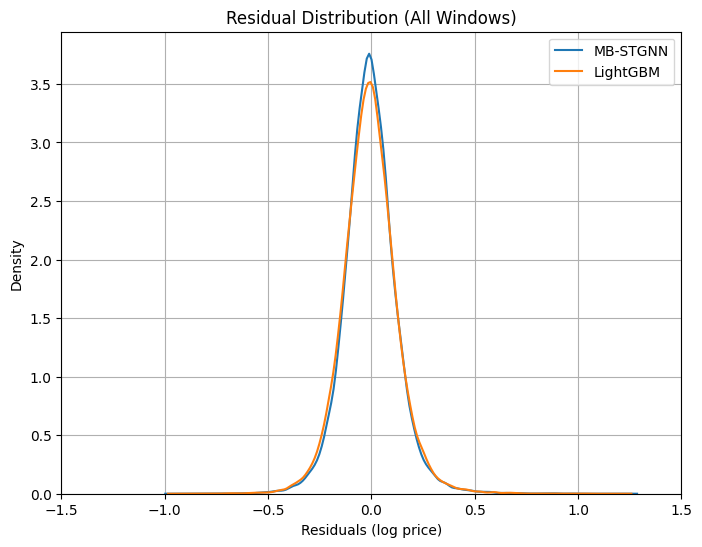

In [39]:
import seaborn as sns
# merged_df['residual_baseline'] = merged_df['y_pred_macro_graph_baseline'] - merged_df['y_true']
merged_df['residual_final'] = merged_df['y_pred_mbstgnn'] - merged_df['y_true']
merged_df['residual_lgbm'] = merged_df['y_pred_lgbm'] - merged_df['y_true']

plt.figure(figsize=(8, 6))
# sns.kdeplot(merged_df['residual_baseline'], label='MacroGNN-MLP')
sns.kdeplot(merged_df['residual_final'], label='MB-STGNN')
sns.kdeplot(merged_df['residual_lgbm'], label='LightGBM')
plt.title('Residual Distribution (All Windows)')
plt.xlabel('Residuals (log price)')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

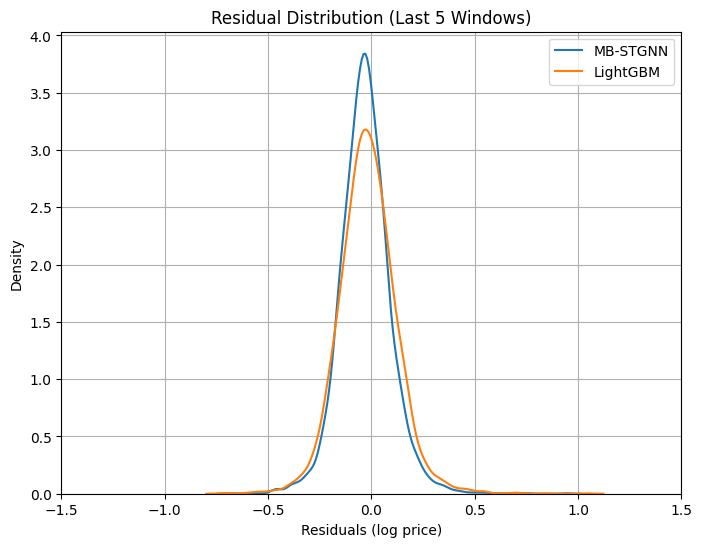

In [40]:
N = 5

last_N_dates = merged_df['DATE'].sort_values().unique()[-N:]
residuals_last_N = merged_df[merged_df['DATE'].isin(last_N_dates)]

plt.figure(figsize=(8, 6))
# sns.kdeplot(residuals_last_N['residual_baseline'], label='MacroGNN-MLP')
sns.kdeplot(residuals_last_N['residual_final'], label='MB-STGNN')
sns.kdeplot(residuals_last_N['residual_lgbm'], label='LightGBM')
plt.title(f'Residual Distribution (Last {N} Windows)')
plt.xlabel('Residuals (log price)')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

### Performance by property type

In [41]:
transaction_df = pd.read_csv("../../housing-data/synthetic_transactions.csv")

combined_df = pd.merge(merged_df, transaction_df, on=['TRANSID', 'BUURTCODE'], how='left')
print(combined_df.columns)

Index(['window_start', 'BUURTCODE', 'TRANSID', 'y_true',
       'y_pred_macro_graph_baseline', 'y_pred_mbstgnn', 'y_pred_lgbm', 'DATE',
       'residual_final', 'residual_lgbm', 'DATUM', 'WONINGTYPE', 'SOC',
       'CALCOPP', 'KAVOPP', 'BOUWJAAR', 'LAT', 'LON', 'BESTEMMING',
       'DUMMY_BERGING', 'DUMMY_GARAGE', 'DUMMY_MONUMENT', 'LOG_KOOPSOM'],
      dtype='object')


In [42]:
##############################################################################
# 1. Helper to compute metrics + count
##############################################################################
def metrics_per_model(g: pd.DataFrame, model_col: str) -> pd.Series:
    """Return MSE, SD(MSE), MAPE, SD(MAPE) for one prediction column."""
    se  = (g["y_true"] - g[model_col]) ** 2
    ape = np.abs((np.exp(g["y_true"]) - np.exp(g[model_col])) / np.exp(g["y_true"])) * 100
    return pd.Series({
        f"MSE_{model_col}"   : se.mean(),
        f"MSEsd_{model_col}" : se.std(ddof=1),
        f"MAPE_{model_col}"  : ape.mean(),
        f"MAPEsd_{model_col}": ape.std(ddof=1)
    })

##############################################################################
# 2. Aggregate over the *entire* data  (with counts)
##############################################################################
model_cols = [ "y_pred_mbstgnn", "y_pred_lgbm"]

metrics_all = (
    combined_df
    .groupby("WONINGTYPE", sort=False)
    .apply(
        lambda g: pd.concat(
            [metrics_per_model(g, m) for m in model_cols] +  # metrics
            [pd.Series({"count": len(g)})]                   # ← add count here
        )
    )
    .reset_index()
)

##############################################################################
# 3. Aggregate over the last 5 windows  (with counts)
##############################################################################
last5_mask = combined_df["window_start"].isin(
    combined_df["window_start"].drop_duplicates().sort_values().tail(5)
)
last5 = combined_df[last5_mask]

metrics_last5 = (
    last5
    .groupby("WONINGTYPE", sort=False)
    .apply(
        lambda g: pd.concat(
            [metrics_per_model(g, m) for m in model_cols] +
            [pd.Series({"count": len(g)})]
        )
    )
    .reset_index()
)

##############################################################################
# 4. Preview
##############################################################################
pd.set_option("display.float_format", "{:,.4f}".format)

print("=== Full horizon ===")
print(metrics_all.head())

print("\n=== Last 5 windows ===")
print(metrics_last5.head())
mse_metrics = metrics_last5[['WONINGTYPE',  'MSE_y_pred_mbstgnn', 'MSE_y_pred_lgbm', 'count']]
print(mse_metrics.to_latex())
mape_metrics = metrics_last5[['WONINGTYPE',  'MAPE_y_pred_mbstgnn', 'MAPE_y_pred_lgbm', 'count']]
print(mape_metrics.to_latex())

# [array(['A', 'H', 'K', 'T', 'V'])]

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_14968\1377220791.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


ValueError: cannot insert WONINGTYPE, already exists

## Temporal Generalization

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_14968\2303513835.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_std_per_window = merged_df.groupby('DATE').apply(


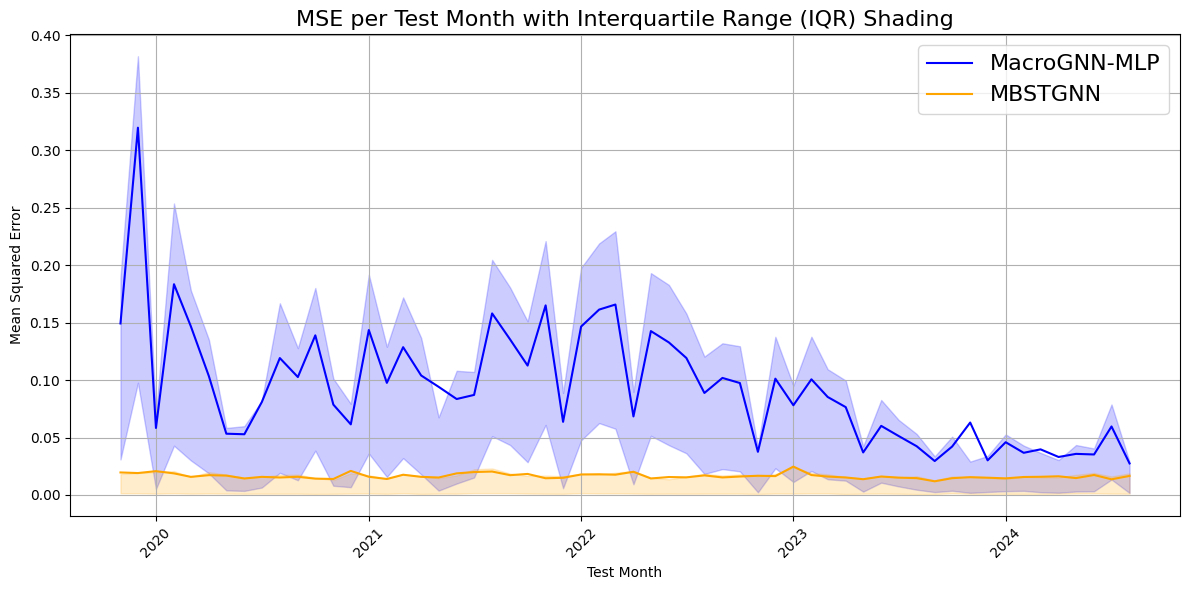

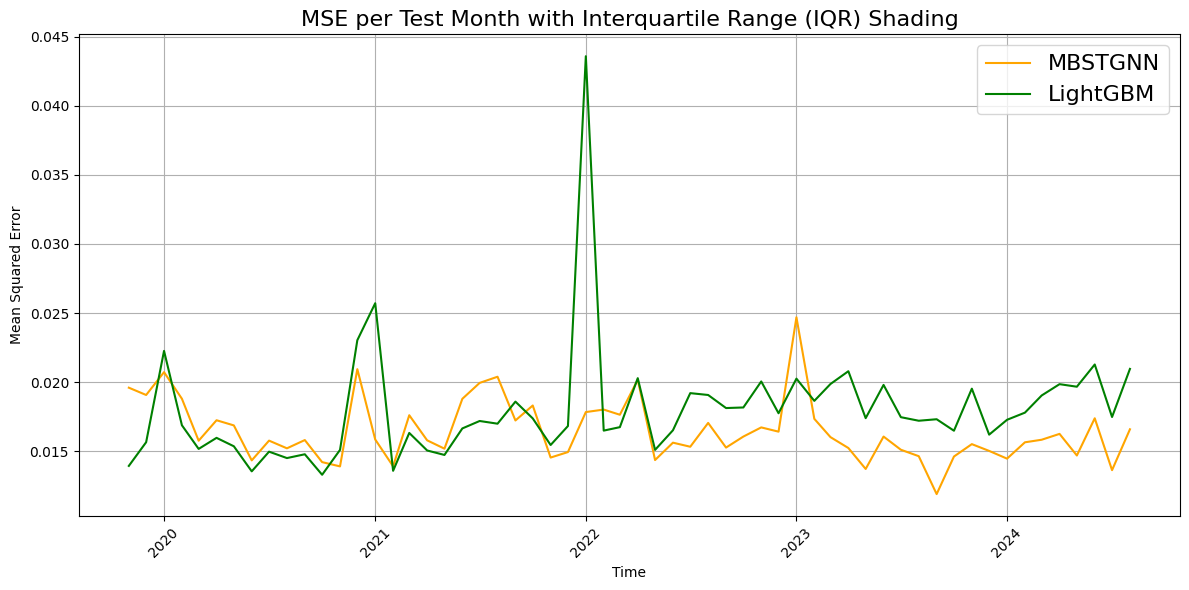

In [43]:
# Calculate MSE and standard deviation per window for baseline and final predictions
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_baseline': np.mean((x['y_true'] - x['y_pred_macro_graph_baseline']) ** 2),
        'upper_baseline': np.quantile((x['y_true'] - x['y_pred_macro_graph_baseline']) ** 2, 0.75),
        'lower_baseline': np.quantile((x['y_true'] - x['y_pred_macro_graph_baseline']) ** 2, 0.25),
        'mse_final': np.mean((x['y_true'] - x['y_pred_mbstgnn']) ** 2),
        'upper_final': np.quantile((x['y_true'] - x['y_pred_mbstgnn']) ** 2, 0.75),
        'lower_final': np.quantile((x['y_true'] - x['y_pred_mbstgnn']) ** 2, 0.25),
        'mse_lgbm': np.mean((x['y_true'] - x['y_pred_lgbm']) ** 2),
        'upper_lgbm': np.quantile((x['y_true'] - x['y_pred_lgbm']) ** 2, 0.75),
        'lower_lgbm': np.quantile((x['y_true'] - x['y_pred_lgbm']) ** 2, 0.25),
        # 'mse_mbstgnn_uni': np.mean((x['y_true'] - x['y_pred_mbstgnn_uni']) ** 2),
        # 'upper_mbstgnn_uni': np.quantile((x['y_true'] - x['y_pred_mbstgnn_uni']) ** 2, 0.75),
        # 'lower_mbstgnn_uni': np.quantile((x['y_true'] - x['y_pred_mbstgnn_uni']) ** 2, 0.25)
    })
).reset_index()

# Plot the MSE per window with standard deviation as shaded area
plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_baseline'], label='MacroGNN-MLP', color='blue')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_baseline'],
    mse_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='MBSTGNN', color='orange')
plt.fill_between(
    mse_std_per_window['DATE'],
    mse_std_per_window['lower_final'],
    mse_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
# plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LightGBM', color='green')
# plt.fill_between(
#     mse_std_per_window['DATE'], 
#     mse_std_per_window['lower_lgbm'],
#     mse_std_per_window['upper_lgbm'],
#     color='green', alpha=0.2
# )
# plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_uni'], label='MBSTGNN-Uni', color='purple')
# plt.fill_between(
#     mse_std_per_window['DATE'],
#     mse_std_per_window['lower_mbstgnn_uni'],
#     mse_std_per_window['upper_mbstgnn_uni'],
#     color='purple', alpha=0.2
# )
plt.xlabel('Test Month')
plt.ylabel('Mean Squared Error')
plt.title('MSE per Test Month with Interquartile Range (IQR) Shading', fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()


# Plot for proposed model and lightgbm
plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_final'], label='MBSTGNN', color='orange')
# plt.fill_between(
#     mse_std_per_window['DATE'],
#     mse_std_per_window['lower_final'],
#     mse_std_per_window['upper_final'],
#     color='orange', alpha=0.2
# )
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_lgbm'], label='LightGBM', color='green')
# plt.fill_between(
#     mse_std_per_window['DATE'], 
#     mse_std_per_window['lower_lgbm'],
#     mse_std_per_window['upper_lgbm'],
#     color='green', alpha=0.2
# )
# plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_uni'], label='MBSTGNN-Uni', color='red')
# plt.fill_between(
#     mse_std_per_window['DATE'],
#     mse_std_per_window['lower_mbstgnn_uni'],
#     mse_std_per_window['upper_mbstgnn_uni'],
#     color='red', alpha=0.2
# )
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('MSE per Test Month with Interquartile Range (IQR) Shading', fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# compare_models(mse_std_per_window['mse_final'], mse_std_per_window['mse_mbstgnn_uni'], name_a='MBST-GNN', name_b='LGBM')

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_14968\1460040736.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_std_per_window = merged_df.groupby('DATE').apply(


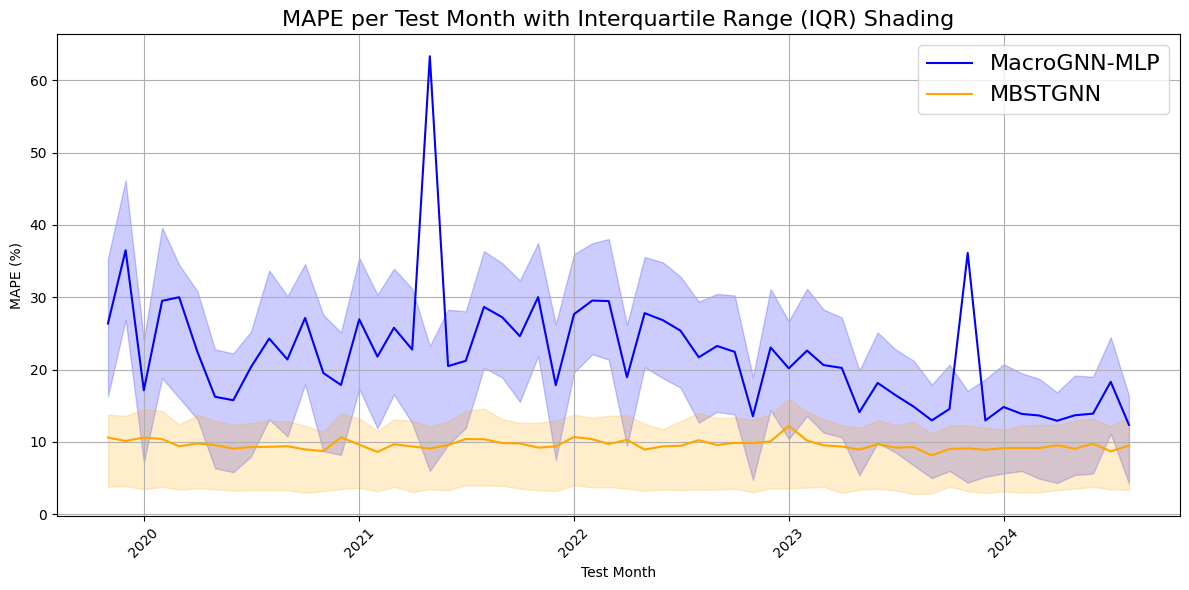

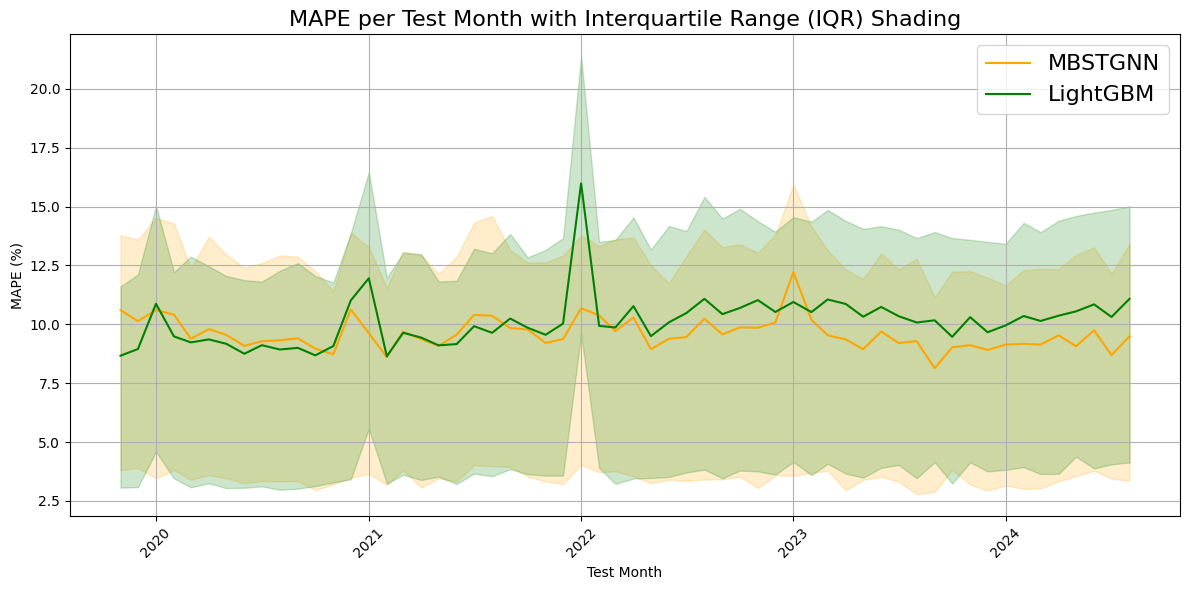

In [ ]:
mape_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mape_baseline': mape(np.exp(x['y_true']), np.exp(x['y_pred_macro_graph_baseline'])),
        'std_baseline': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_macro_graph_baseline'])),
        'lower_baseline': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_macro_graph_baseline']), 0.25),
        'upper_baseline': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_macro_graph_baseline']), 0.75),
        'mape_final': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn'])),
        'std_final': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn'])),
        'lower_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn']), 0.25),
        'upper_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn']), 0.75),
        'mape_lgbm': mape(np.exp(x['y_true']), np.exp(x['y_pred_lgbm'])),
        'std_lgbm': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_lgbm'])),
        'lower_lgbm': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_lgbm']), 0.25),
        'upper_lgbm': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_lgbm']), 0.75),
        # 'mape_mbstgnn_uni': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_uni'])),
        # 'std_mbstgnn_uni': mape_std(np.exp(x['y_true']),    np.exp(x['y_pred_mbstgnn_uni'])),
        # 'lower_mbstgnn_uni': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_uni']), 0.25),
        # 'upper_mbstgnn_uni': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_uni']), 0.75)
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_baseline'], label='MacroGNN-MLP',color='blue')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_baseline'],
    mape_std_per_window['upper_baseline'],
    color='blue', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='MBSTGNN',color='orange')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_final'],
    mape_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
# plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_lgbm'], label='LightGBM',color='green')
# plt.fill_between(
#     mape_std_per_window['DATE'],
#     mape_std_per_window['lower_lgbm'],
#     mape_std_per_window['upper_lgbm'],
#     color='green', alpha=0.2
# )
plt.xlabel('Test Month')
plt.ylabel('MAPE (%)')
plt.title('MAPE per Test Month with Interquartile Range (IQR) Shading', fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot for proposed model and lightgbm

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='MBSTGNN',color='orange')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_final'],
    mape_std_per_window['upper_final'],
    color='orange', alpha=0.2
)
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_lgbm'], label='LightGBM',color='green')
plt.fill_between(
    mape_std_per_window['DATE'],
    mape_std_per_window['lower_lgbm'],
    mape_std_per_window['upper_lgbm'],
    color='green', alpha=0.2
)
# plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_mbstgnn_uni'], label='MBSTGNN-Uni',color='purple')
# plt.fill_between(
#     mape_std_per_window['DATE'],
#     mape_std_per_window['lower_mbstgnn_uni'],
#     mape_std_per_window['upper_mbstgnn_uni'],
#     color='purple', alpha=0.2
# )
plt.xlabel('Test Month')
plt.ylabel('MAPE (%)')
plt.title('MAPE per Test Month with Interquartile Range (IQR) Shading', fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# compare_models(
#     (merged_df['y_pred_mbstgnn'] - merged_df['y_true']) ** 2, 
#     (merged_df['y_pred_mbstgnn_uni'] - merged_df['y_true']) ** 2, 
#     # name_a='MBST-GNN', 
#     name_b='MBST-GNN-Uni'
# )

In [ ]:
compare_models(
    errors_a=mse_std_per_window['mse_lgbm'] ,
    errors_b=mse_std_per_window['mse_final'],
    name_a='LightGBM',
    name_b='MB-STGNN'
)


compare_models(
    errors_a=mape_std_per_window['mape_lgbm'] ,
    errors_b=mape_std_per_window['mape_final'],
    name_a='LightGBM',
    name_b='MB-STGNN'
)

=== Model Comparison ===
Mean LightGBM Error: 0.0520
Mean MB-STGNN Error: 0.0389
Mean Difference (A - B): 0.0131
Winner: MB-STGNN

Wilcoxon Test:     stat = 5.0, p = 6.494193889902272e-13
Diebold-Mariano:  stat = 15.2321, p = 0.0000
=== Model Comparison ===
Mean LightGBM Error: 17.6921
Mean MB-STGNN Error: 15.0732
Mean Difference (A - B): 2.6189
Winner: MB-STGNN

Wilcoxon Test:     stat = 76.0, p = 1.331456061408439e-11
Diebold-Mariano:  stat = 12.4294, p = 0.0000


{'winner': 'MB-STGNN',
 'wilcoxon_stat': 76.0,
 'wilcoxon_p': 1.331456061408439e-11,
 'dm_stat': 12.429362789353943,
 'dm_p': 1.8107193295272102e-35}

In [ ]:
# Find the avg mape, mse and repsetive standard deviation for each model for the last 10 windows
mse_last_10_windows = mse_std_per_window.tail(5)
# print("Last 10 Windows MSE and MAPE:")
# print(mse_last_10_windows[['DATE', 'mse_baseline', 'mse_final', 'mse_lgbm']])   
# print("Last 10 Windows MAPE:")
mape_last_10_windows = mape_std_per_window.tail(5)
# print(mape_last_10_windows[['DATE', 'mape_baseline', 'mape_final', 'mape_lgbm']])

#find the avg mape and mse for the last 10 windows
avg_mse_last_10 = mse_last_10_windows[['mse_baseline', 'mse_final', 'mse_lgbm']].mean()
std_mse_last_10 = mse_last_10_windows[['mse_baseline', 'mse_final', 'mse_lgbm']].std()
avg_mape_last_10 = mape_last_10_windows[['mape_baseline', 'mape_final', 'mape_lgbm']].mean()
std_mape_last_10 = mape_last_10_windows[['mape_baseline', 'mape_final', 'mape_lgbm']].std()

print(f"Average MSE for the last 5 windows - Baseline: {avg_mse_last_10['mse_baseline']:.4f} (Std: {std_mse_last_10['mse_baseline']:.4f}), Final: {avg_mse_last_10['mse_final']:.4f} (Std: {std_mse_last_10['mse_final']:.4f}), LGBM: {avg_mse_last_10['mse_lgbm']:.4f} (Std: {std_mse_last_10['mse_lgbm']:.4f})")
print(f"Average MAPE for the last 5 windows - Baseline: {avg_mape_last_10['mape_baseline']:.2f}% (Std: {std_mape_last_10['mape_baseline']:.2f}%), Final: {avg_mape_last_10['mape_final']:.2f}% (Std: {std_mape_last_10['mape_final']:.2f}%), LGBM: {avg_mape_last_10['mape_lgbm']:.2f}% (Std: {std_mape_last_10['mape_lgbm']:.2f}%)")


KeyError: "['mse_baseline'] not in index"

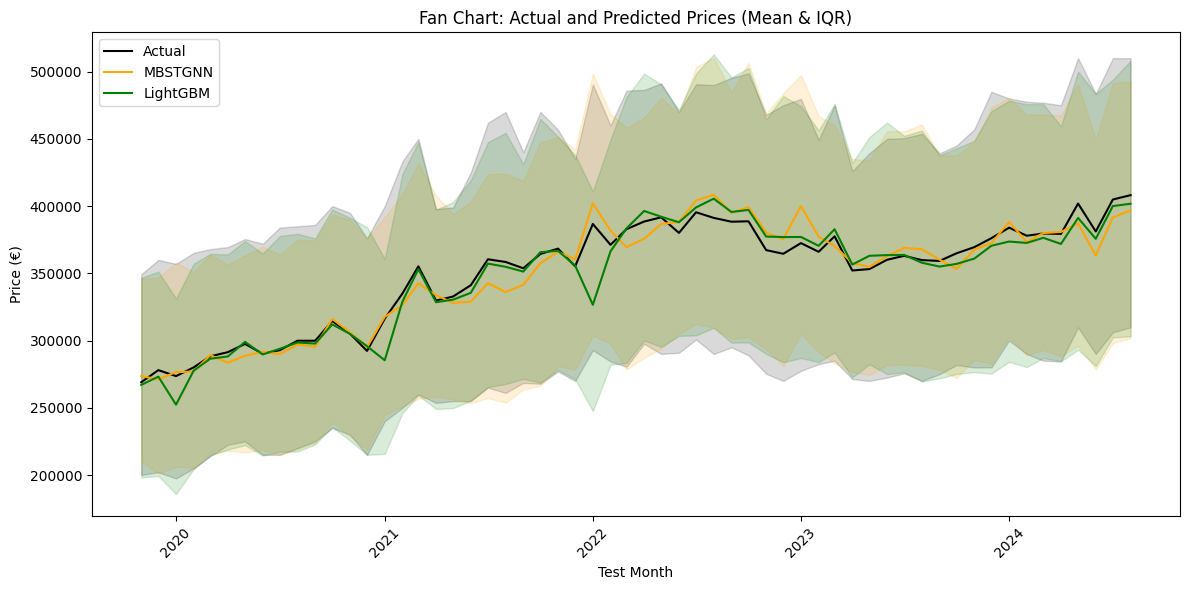

In [44]:
# make a fan chart for the actual log prices and the predicted log prices for all models
# We'll plot the mean and IQR (25th-75th percentile) for each model per month

# Group by DATE and calculate mean and IQR for actual and predicted prices
actual_stats = merged_df.groupby('DATE')['y_true'].agg(['mean', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)]).reset_index()
actual_stats.columns = ['DATE', 'mean', 'q25', 'q75']

# baseline_stats = merged_df.groupby('DATE')['y_pred_macro_graph_baseline'].agg(['mean', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)]).reset_index()
# baseline_stats.columns = ['DATE', 'mean', 'q25', 'q75']

final_stats = merged_df.groupby('DATE')['y_pred_mbstgnn'].agg(['mean', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)]).reset_index()
final_stats.columns = ['DATE', 'mean', 'q25', 'q75']

lgbm_stats = merged_df.groupby('DATE')['y_pred_lgbm'].agg(['mean', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)]).reset_index()
lgbm_stats.columns = ['DATE', 'mean', 'q25', 'q75']

plt.figure(figsize=(12, 6))

# Actual prices
plt.plot(actual_stats['DATE'], np.exp(actual_stats['mean']), label='Actual', color='black')
plt.fill_between(actual_stats['DATE'], np.exp(actual_stats['q25']), np.exp(actual_stats['q75']), color='black', alpha=0.15)

# MacroGNN-MLP
# plt.plot(baseline_stats['DATE'], np.exp(baseline_stats['mean']), label='MacroGNN-MLP', color='blue')
# plt.fill_between(baseline_stats['DATE'], np.exp(baseline_stats['q25']), np.exp(baseline_stats['q75']), color='blue', alpha=0.15)

# MBSTGNN
plt.plot(final_stats['DATE'], np.exp(final_stats['mean']), label='MBSTGNN', color='orange')
plt.fill_between(final_stats['DATE'], np.exp(final_stats['q25']), np.exp(final_stats['q75']), color='orange', alpha=0.15)

# LightGBM
plt.plot(lgbm_stats['DATE'], np.exp(lgbm_stats['mean']), label='LightGBM', color='green')
plt.fill_between(lgbm_stats['DATE'], np.exp(lgbm_stats['q25']), np.exp(lgbm_stats['q75']), color='green', alpha=0.15)

plt.xlabel('Test Month')
plt.ylabel('Price (€)')
plt.title('Fan Chart: Actual and Predicted Prices (Mean & IQR)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
combined_df["price"] = np.exp(combined_df["y_true"])
# combined_df["pred_price_macro_graph_baseline"] = np.exp(combined_df["y_pred_macro_graph_baseline"])
combined_df["pred_price_mbstgnn"] = np.exp(combined_df["y_pred_mbstgnn"])
combined_df["pred_price_lgbm"] = np.exp(combined_df["y_pred_lgbm"])

combined_df["ppsm"] = combined_df["price"] / combined_df["CALCOPP"]
combined_df["log_ppsm"] = np.log(combined_df["ppsm"])

# Add predicted price per square meter columns for each model
# combined_df["ppsm_macro_graph_baseline"] = combined_df["pred_price_macro_graph_baseline"] / combined_df["CALCOPP"]
combined_df["ppsm_mbstgnn"] = combined_df["pred_price_mbstgnn"] / combined_df["CALCOPP"]
combined_df["ppsm_lgbm"] = combined_df["pred_price_lgbm"] / combined_df["CALCOPP"]

# Group by month and aggregate median and quantiles for actual and predicted ppsm
monthly = combined_df.groupby("DATE").agg({
    "ppsm": ["median", lambda x: x.quantile(0.05), lambda x: x.quantile(0.25),
             lambda x: x.quantile(0.75), lambda x: x.quantile(0.95)],
    # "ppsm_macro_graph_baseline": ["median", lambda x: x.quantile(0.05), lambda x: x.quantile(0.25),
    #                               lambda x: x.quantile(0.75), lambda x: x.quantile(0.95)],
    "ppsm_mbstgnn": ["median", lambda x: x.quantile(0.05), lambda x: x.quantile(0.25),
                     lambda x: x.quantile(0.75), lambda x: x.quantile(0.95)],
    "ppsm_lgbm": ["median", lambda x: x.quantile(0.05), lambda x: x.quantile(0.25),
                  lambda x: x.quantile(0.75), lambda x: x.quantile(0.95)]
})

monthly.columns = [
    "actual_median", "actual_p5", "actual_p25", "actual_p75", "actual_p95",
    # "baseline_median", "baseline_p5", "baseline_p25", "baseline_p75", "baseline_p95",
    "mbstgnn_median", "mbstgnn_p5", "mbstgnn_p25", "mbstgnn_p75", "mbstgnn_p95",
    "lgbm_median", "lgbm_p5", "lgbm_p25", "lgbm_p75", "lgbm_p95"
]



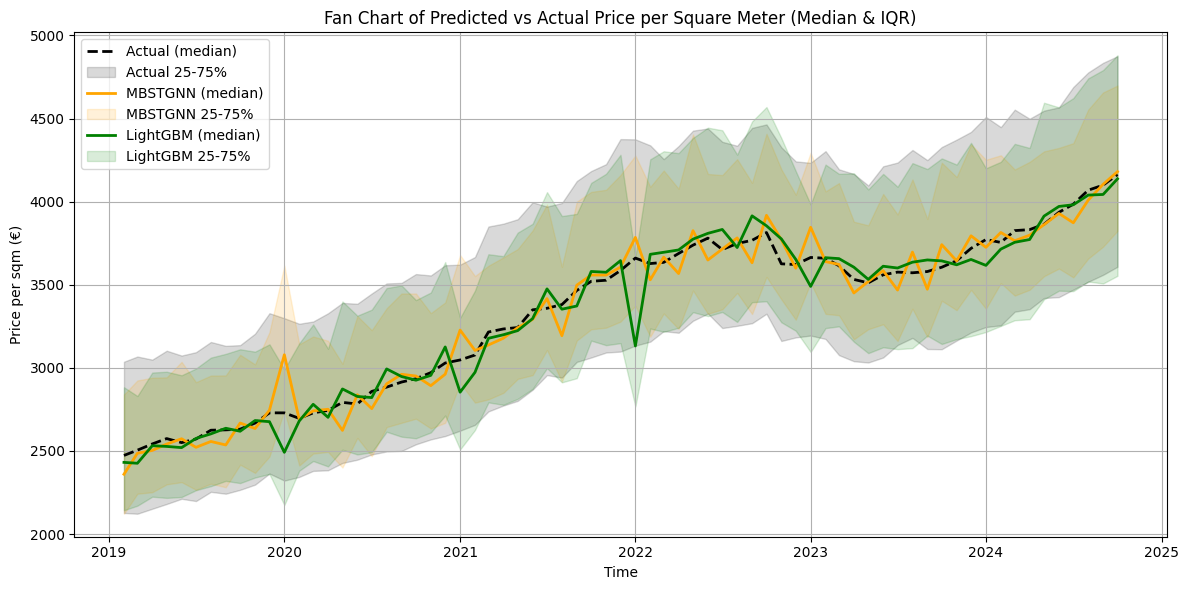

In [ ]:
plt.figure(figsize=(12, 6))

# Actual PPSM
plt.plot(monthly.index, monthly["actual_median"], label="Actual (median)", color="black", linewidth=2, linestyle="--")
plt.fill_between(monthly.index, monthly["actual_p25"], monthly["actual_p75"], color="black", alpha=0.15, label="Actual 25-75%")

# MacroGNN-MLP
# plt.plot(monthly.index, monthly["baseline_median"], label="MacroGNN-MLP (median)", color="blue", linewidth=2)
# plt.fill_between(monthly.index, monthly["baseline_p25"], monthly["baseline_p75"], color="blue", alpha=0.15, label="MacroGNN-MLP 25-75%")

# MBSTGNN
plt.plot(monthly.index, monthly["mbstgnn_median"], label="MBSTGNN (median)", color="orange", linewidth=2)
plt.fill_between(monthly.index, monthly["mbstgnn_p25"], monthly["mbstgnn_p75"], color="orange", alpha=0.15, label="MBSTGNN 25-75%")

# LightGBM
plt.plot(monthly.index, monthly["lgbm_median"], label="LightGBM (median)", color="green", linewidth=2)
plt.fill_between(monthly.index, monthly["lgbm_p25"], monthly["lgbm_p75"], color="green", alpha=0.15, label="LightGBM 25-75%")

plt.ylabel("Price per sqm (€)")
plt.xlabel("Time")
plt.title("Fan Chart of Predicted vs Actual Price per Square Meter (Median & IQR)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## Spatial Analysis

### Heatmaps of Errors

In [46]:
import geopandas as gpd



In [47]:
gemeentes_rotterdam = ['GM1930','GM0502', 'GM0622','GM0597',
 'GM0556',
 'GM0489',
 'GM0606',
 'GM1621',
 'GM1992',
 'GM0613',
 'GM0542',
 'GM0599']

In [48]:
gdf_2023= gpd.read_file("../../housing-data/cbsgebiedsindelingen2016-2025/cbsgebiedsindelingen2023.gpkg", layer="buurt_gegeneraliseerd")
gdf_2023

statcode      jrstatcode                   statnaam gm_code rubriek  \
0      BU00340101  2023BU00340101        Centrum Haven Noord  GM0034   buurt   
1      BU00340102  2023BU00340102         Centrum Haven Zuid  GM0034   buurt   
2      BU00340201  2023BU00340201  Rozenwerf en Tuinderswerf  GM0034   buurt   
3      BU00340202  2023BU00340202                 Achterwerf  GM0034   buurt   
4      BU00340203  2023BU00340203     Goedewerf en Wittewerf  GM0034   buurt   
...           ...             ...                        ...     ...     ...   
14416  BU03850501  2023BU03850501                     Warder  GM0385   buurt   
14417  BU03850601  2023BU03850601                   Middelie  GM0385   buurt   
14418  BU03850701  2023BU03850701                    Kwadijk  GM0385   buurt   
14419  BU03850801  2023BU03850801                   Schardam  GM0385   buurt   
14420  BU03850901  2023BU03850901                    Hobrede  GM0385   buurt   

          id                                           geometry  
0          1  MULTIPOLYGON (((143508.204 483344.282, 143707....  
1          2  MULTIPOLYGON (((143728.65 483029.012, 143730.8...  
2          3  MULTIPOLYGON (((144118.02 483591.859, 144295.6...  
3          4  MULTIPOLYGON (((144427.109 483263.953, 144384....  
4          5  MULTIPOLYGON (((144267.821 483312.403, 144090....  
...      ...                                                ...  
14416  14417  MULTIPOLYGON (((130959.382 509613.307, 130850....  
14417  14418  MULTIPOLYGON (((128874.917 507747.278, 130244....  
14418  14419  MULTIPOLYGON (((127500.256 506394.557, 128625....  
14419  14420  MULTIPOLYGON (((130104.529 513486.749, 130091....  
14420  14421  MULTIPOLYGON (((128686.265 506233.174, 128625....  

[14421 rows x 7 columns]

In [49]:
gef_rijnmond = gdf_2023[gdf_2023["gm_code"].isin(gemeentes_rotterdam)]
gef_rijnmond

statcode      jrstatcode             statnaam gm_code rubriek     id  \
3657   BU04890101  2023BU04890101              Centrum  GM0489   buurt   3658   
3658   BU04890102  2023BU04890102         Centrum Oost  GM0489   buurt   3659   
3659   BU04890103  2023BU04890103         Centrum West  GM0489   buurt   3660   
3660   BU04890204  2023BU04890204              Noord 1  GM0489   buurt   3661   
3661   BU04890205  2023BU04890205              Noord 2  GM0489   buurt   3662   
...           ...             ...                  ...     ...     ...    ...   
11055  BU06061005  2023BU06061005  Sveaborg en Sveadal  GM0606   buurt  11056   
11056  BU06061006  2023BU06061006             Sveaholm  GM0606   buurt  11057   
11057  BU06061007  2023BU06061007             Sveafors  GM0606   buurt  11058   
11058  BU06061101  2023BU06061101    Noordkethelpolder  GM0606   buurt  11059   
11059  BU06061102  2023BU06061102       Polderwetering  GM0606   buurt  11060   

                                                geometry  
3657   MULTIPOLYGON (((96663.776 430002.591, 96789.07...  
3658   MULTIPOLYGON (((97129.146 429625.191, 97107.28...  
3659   MULTIPOLYGON (((96381.123 430511.161, 96378.71...  
3660   MULTIPOLYGON (((97237.35 430420.163, 96907.768...  
3661   MULTIPOLYGON (((96943.148 430037.773, 96680.87...  
...                                                  ...  
11055  MULTIPOLYGON (((86214.444 440408.06, 86202.202...  
11056  MULTIPOLYGON (((86202.202 440011.621, 86214.99...  
11057  MULTIPOLYGON (((86357.781 439375.809, 86037.76...  
11058  MULTIPOLYGON (((86040.048 441170.913, 85699.00...  
11059  MULTIPOLYGON (((86040.048 441170.913, 86365.07...  

[625 rows x 7 columns]

In [60]:
rott_adj = pd.read_csv("../../housing-data/rotterdam_adj_2023.csv", index_col=0)
rott_adj

BU04890101  BU04890102  BU04890103  BU04890204  BU04890205  \
BU04890101         0.0         1.0         1.0         1.0         0.0   
BU04890102         1.0         0.0         0.0         0.0         0.0   
BU04890103         1.0         0.0         0.0         1.0         0.0   
BU04890204         1.0         0.0         1.0         0.0         1.0   
BU04890205         0.0         0.0         0.0         1.0         0.0   
...                ...         ...         ...         ...         ...   
BU06061005         0.0         0.0         0.0         0.0         0.0   
BU06061006         0.0         0.0         0.0         0.0         0.0   
BU06061007         0.0         0.0         0.0         0.0         0.0   
BU06061101         0.0         0.0         0.0         0.0         0.0   
BU06061102         0.0         0.0         0.0         0.0         0.0   

            BU04890206  BU04890207  BU04890308  BU04890409  BU04890410  ...  \
BU04890101         1.0         0.0         0.0         0.0         0.0  ...   
BU04890102         1.0         0.0         0.0         1.0         0.0  ...   
BU04890103         0.0         0.0         0.0         0.0         0.0  ...   
BU04890204         1.0         0.0         1.0         0.0         0.0  ...   
BU04890205         1.0         0.0         1.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
BU06061005         0.0         0.0         0.0         0.0         0.0  ...   
BU06061006         0.0         0.0         0.0         0.0         0.0  ...   
BU06061007         0.0         0.0         0.0         0.0         0.0  ...   
BU06061101         0.0         0.0         0.0         0.0         0.0  ...   
BU06061102         0.0         0.0         0.0         0.0         0.0  ...   

            BU06060904  BU06061001  BU06061002  BU06061003  BU06061004  \
BU04890101         0.0         0.0         0.0         0.0         0.0   
BU04890102         0.0         0.0         0.0         0.0         0.0   
BU04890103         0.0         0.0         0.0         0.0         0.0   
BU04890204         0.0         0.0         0.0         0.0         0.0   
BU04890205         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
BU06061005         0.0         0.0         1.0         1.0         1.0   
BU06061006         0.0         1.0         1.0         0.0         0.0   
BU06061007         0.0         1.0         1.0         0.0         0.0   
BU06061101         0.0         0.0         0.0         0.0         1.0   
BU06061102         0.0         1.0         0.0         0.0         0.0   

            BU06061005  BU06061006  BU06061007  BU06061101  BU06061102  
BU04890101         0.0         0.0         0.0         0.0         0.0  
BU04890102         0.0         0.0         0.0         0.0         0.0  
BU04890103         0.0         0.0         0.0         0.0         0.0  
BU04890204         0.0         0.0         0.0         0.0         0.0  
BU04890205         0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
BU06061005         0.0         1.0         0.0         1.0         1.0  
BU06061006         1.0         0.0         1.0         0.0         1.0  
BU06061007         0.0         1.0         0.0         0.0         1.0  
BU06061101         1.0         0.0         0.0         0.0         1.0  
BU06061102         1.0         1.0         1.0         1.0         0.0  

[625 rows x 625 columns]

In [61]:
buurt_codes = rott_adj.columns.tolist()
buurt_codes

['BU04890101',
 'BU04890102',
 'BU04890103',
 'BU04890204',
 'BU04890205',
 'BU04890206',
 'BU04890207',
 'BU04890308',
 'BU04890409',
 'BU04890410',
 'BU04890511',
 'BU04890512',
 'BU04890513',
 'BU04890614',
 'BU04890715',
 'BU04890816',
 'BU04890817',
 'BU04890918',
 'BU04890919',
 'BU04890920',
 'BU04890921',
 'BU04890922',
 'BU04891023',
 'BU04891124',
 'BU04891225',
 'BU04891226',
 'BU04891227',
 'BU04891328',
 'BU04891429',
 'BU04891430',
 'BU04891431',
 'BU04891432',
 'BU04891533',
 'BU04891634',
 'BU04891735',
 'BU04891836',
 'BU04891937',
 'BU04892039',
 'BU04893050',
 'BU04893051',
 'BU04893052',
 'BU04893053',
 'BU04893054',
 'BU04893160',
 'BU04893161',
 'BU04893162',
 'BU04893163',
 'BU04893164',
 'BU04895070',
 'BU04895071',
 'BU04895072',
 'BU04895073',
 'BU04895074',
 'BU04895075',
 'BU04895076',
 'BU04895077',
 'BU04895078',
 'BU04895080',
 'BU04895081',
 'BU04895082',
 'BU04895083',
 'BU04895084',
 'BU05020110',
 'BU05020111',
 'BU05020112',
 'BU05020113',
 'BU050201

In [62]:
combined_df

window_start  BUURTCODE  TRANSID     y_true  \
0          2014-10        209  5793455  12.863593   
1          2014-10        386  5785580  12.847926   
2          2014-10        207  5796120  12.334906   
3          2014-10        281  5782777  12.278394   
4          2014-10         73  5796410  12.072541   
...            ...        ...      ...        ...   
54666      2019-07        238  8722107  12.948010   
54667      2019-07        189  8739935  12.994530   
54668      2019-07        207  8724698  12.786891   
54669      2019-07        169  8722063  13.102160   
54670      2019-07        252  8734801  12.666657   

       y_pred_macro_graph_baseline  y_pred_mbstgnn  y_pred_lgbm       DATE  \
0                        12.703348       12.905668    12.847588 2019-11-01   
1                        12.533681       12.920620    13.027783 2019-11-01   
2                        12.206609       12.390343    12.402420 2019-11-01   
3                        12.256974       12.559343    12.384548 2019-11-01   
4                        11.832530       12.047544    12.059921 2019-11-01   
...                            ...             ...          ...        ...   
54666                    12.916648       12.840471    12.742786 2024-08-01   
54667                    12.883138       12.873444    12.733351 2024-08-01   
54668                    12.781923       12.656372    12.767760 2024-08-01   
54669                    13.104159       13.108351    13.184609 2024-08-01   
54670                    12.385764       12.521019    12.420233 2024-08-01   

       residual_final  residual_lgbm  ... DUMMY_GARAGE  DUMMY_MONUMENT  \
0            0.042075      -0.016005  ...          NaN             NaN   
1            0.072694       0.179857  ...          NaN             NaN   
2            0.055437       0.067514  ...          NaN             NaN   
3            0.280949       0.106154  ...          NaN             NaN   
4           -0.024997      -0.012620  ...          NaN             NaN   
...               ...            ...  ...          ...             ...   
54666       -0.107539      -0.205224  ...          NaN             NaN   
54667       -0.121086      -0.261179  ...          NaN             NaN   
54668       -0.130519      -0.019131  ...          NaN             NaN   
54669        0.006191       0.082449  ...          NaN             NaN   
54670       -0.145638      -0.246424  ...          NaN             NaN   

       LOG_KOOPSOM          price  pred_price_mbstgnn  pred_price_lgbm  ppsm  \
0              NaN  386000.135699       402587.603256    379871.449371   NaN   
1              NaN  379999.797953       408652.319935    454877.118167   NaN   
2              NaN  227500.109798       240468.167476    243389.900222   NaN   
3              NaN  215000.148971       284743.199878    239078.783597   NaN   
4              NaN  174999.955742       170679.703478    172805.318728   NaN   
...            ...            ...                 ...              ...   ...   
54666          NaN  420000.004091       377177.432897    342075.155984   NaN   
54667          NaN  439999.997406       389821.413840    338862.777698   NaN   
54668          NaN  357500.128301       313756.347406    350725.909648   NaN   
54669          NaN  489999.671658       493042.669505    532112.094045   NaN   
54670          NaN  316999.983244       274037.160928    247764.199986   NaN   

       log_ppsm  ppsm_mbstgnn  ppsm_lgbm  
0           NaN           NaN        NaN  
1           NaN           NaN        NaN  
2           NaN           NaN        NaN  
3           NaN           NaN        NaN  
4           NaN           NaN        NaN  
...         ...           ...        ...  
54666       NaN           NaN        NaN  
54667       NaN           NaN        NaN  
54668       NaN           NaN        NaN  
54669       NaN           NaN        NaN  
54670       NaN           NaN        NaN  

[54671 rows x 30 columns]

In [64]:
# replace buurtcodes in combined df with actual names in the buurt_codes list. The buurtcodes in the BUURTCODE column of the combined_df are the indexes of their corresponding buurt names in the buurt_codes list.
combined_df["BUURTCODE"] = combined_df["BUURTCODE"].apply(lambda x: buurt_codes[int(x)] )

In [65]:
zero_pop = ["BU05992705", "BU05992650", "BU05992540",  "BU05992308", "BU05992307", "BU05992306", "BU05992295", "BU05992198"]

In [66]:
# remove rows with zero population

In [67]:
last12 = (
    combined_df["window_start"]          # or whatever your column is called
    .dropna()
    .sort_values()
    .unique()[-12:]                    # last 12 distinct windows
)

# ── 2.  Keep rows that belong to those windows ─────────────────────────────────
df_last12 = combined_df[combined_df["window_start"].isin(last12)]

# ── 3.  Compute Count, MSE, and MAPE per Buurtcode ─────────────────────────────
metrics_df = (
    df_last12
    .groupby("BUURTCODE")
    .apply(lambda g: pd.Series({
        "Count": len(g),
        "MSE_mbstgnn":   np.median((g["y_true"] - g["y_pred_mbstgnn"])**2),
        "MAPE_mbstgnn":  np.median(np.abs((np.exp(g["y_true"]) - np.exp(g["y_pred_mbstgnn"])) / np.exp(g["y_true"]))) * 100,
        "MSE_lgbm" :  np.median((g["y_true"] - g["y_pred_lgbm"])**2),
        "MAPE_lgbm": np.median(np.abs((np.exp(g["y_true"]) - np.exp(g["y_pred_lgbm"])) / np.exp(g["y_true"]))) * 100,
        # "MSE_macro_graph_baseline": np.median((g["y_true"] - g["y_pred_macro_graph_baseline"])**2),
        # "MAPE_macro_graph_baseline": np.median(np.abs((np.exp(g["y_true"]) - np.exp(g["y_pred_macro_graph_baseline"])) / np.exp(g["y_true"]))) * 100
    }))
    .reset_index()
)



merged = gef_rijnmond.merge(metrics_df, left_on='statcode', right_on='BUURTCODE', how='outer')
merged.fillna(0, inplace=True)
sorted_df = merged.sort_values(by="Count", ascending=False)
sorted_df.head(20)

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_14968\1268577899.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


statcode      jrstatcode              statnaam gm_code rubriek    id  \
363  BU06130626  2023BU06130626           De Eilanden  GM0613   buurt  4618   
339  BU06130101  2023BU06130101           Valckesteyn  GM0613   buurt  4594   
391  BU06220602  2023BU06220602           Statenbuurt  GM0622   buurt  4646   
404  BU06220801  2023BU06220801    Broekpolder gebied  GM0622   buurt  4659   
368  BU06220104  2023BU06220104              Hoogstad  GM0622   buurt  4623   
362  BU06130625  2023BU06130625     Wijkpark Portland  GM0613   buurt  4617   
398  BU06220703  2023BU06220703           Loper Noord  GM0622   buurt  4653   
367  BU06220103  2023BU06220103               Centrum  GM0622   buurt  4622   
413  BU16211411  2023BU16211411          Wilderszijde  GM1621   buurt  7081   
375  BU06220302  2023BU06220302            Lickebaert  GM0622   buurt  4630   
406  BU16211121  2023BU16211121           De Driehoek  GM1621   buurt  7074   
365  BU06220101  2023BU06220101        Indische Buurt  GM0622   buurt  4620   
371  BU06220203  2023BU06220203              Wetering  GM0622   buurt  4626   
349  BU06130312  2023BU06130312  Polder Albrandswaard  GM0613   buurt  4604   
428  BU16212311  2023BU16212311            Merenbuurt  GM1621   buurt  7096   
397  BU06220702  2023BU06220702          Kruidenbuurt  GM0622   buurt  4652   
390  BU06220601  2023BU06220601            Vaart Zuid  GM0622   buurt  4645   
351  BU06130414  2023BU06130414         Rhoon-Centrum  GM0613   buurt  4606   
403  BU06220708  2023BU06220708           Vaart Noord  GM0622   buurt  4658   
412  BU16211331  2023BU16211331      Boterdorpse Zoom  GM1621   buurt  7080   

                                              geometry   BUURTCODE  Count  \
363  MULTIPOLYGON (((92992.22 429275.981, 92975.409...  BU06130626  234.0   
339  MULTIPOLYGON (((87272.18 431246.118, 87336.696...  BU06130101  226.0   
391  MULTIPOLYGON (((83763.49 438469.592, 83931.973...  BU06220602  213.0   
404  MULTIPOLYGON (((81885.823 439777.56, 82130.953...  BU06220801  173.0   
368  MULTIPOLYGON (((83109.102 436862.269, 82835.12...  BU06220104  167.0   
362  MULTIPOLYGON (((93160.447 429520.22, 92180.045...  BU06130625  164.0   
398  MULTIPOLYGON (((83655.067 438779.014, 83084.54...  BU06220703  143.0   
367  MULTIPOLYGON (((83282.34 436352.299, 83269.832...  BU06220103  139.0   
413  MULTIPOLYGON (((92999.301 444696.36, 93758.867...  BU16211411  136.0   
375  MULTIPOLYGON (((80256.758 435902.691, 80142.84...  BU06220302  132.0   
406  MULTIPOLYGON (((95160.825 445196.655, 94697.82...  BU16211121  124.0   
365  MULTIPOLYGON (((82835.122 436822.826, 82623.88...  BU06220101  121.0   
371  MULTIPOLYGON (((82290.498 437135.148, 82324.25...  BU06220203  120.0   
349  MULTIPOLYGON (((86504.646 430042.994, 86959.92...  BU06130312  118.0   
428  MULTIPOLYGON (((92856.802 446362.488, 92807.56...  BU16212311  116.0   
397  MULTIPOLYGON (((83442.484 439001.67, 83447.94 ...  BU06220702  115.0   
390  MULTIPOLYGON (((83222.976 438206.432, 83452.46...  BU06220601  115.0   
351  MULTIPOLYGON (((88681.723 430189.816, 88213.29...  BU06130414  111.0   
403  MULTIPOLYGON (((82644.219 439061.536, 82769.89...  BU06220708  105.0   
412  MULTIPOLYGON (((93566.392 445362.808, 93267.69...  BU16211331  101.0   

     MSE_mbstgnn  MAPE_mbstgnn  MSE_lgbm  MAPE_lgbm  
363     0.008501      8.847337  0.007807   8.825287  
339     0.004775      6.974710  0.005332   7.301645  
391     0.002961      5.295816  0.005207   7.150531  
404     0.005871      7.696618  0.008297   9.237829  
368     0.012425     10.779201  0.010185  10.386672  
362     0.009710      9.601001  0.008466   8.790414  
398     0.003429      5.710939  0.004866   6.777512  
367     0.005145      6.921969  0.009253   9.224548  
413     0.005095      7.061823  0.004558   6.707756  
375     0.004863      6.871026  0.010303   9.855352  
406     0.004534      6.914322  0.010052   9.776006  
365     0.009454      9.995030  0.010174   9.986689  
371     0.006811      8.602

In [68]:
#remove rows with zero population
sorted_df = sorted_df[~sorted_df["statcode"].isin(zero_pop)]
merged_df = merged_df[~merged_df["BUURTCODE"].isin(zero_pop)]

In [69]:
# Top 10 neighborhoods with highest MAPE for each model
top10_mape_macro_graph_baseline = sorted_df.nlargest(20, "MAPE_macro_graph_baseline")[["statnaam", "MAPE_macro_graph_baseline"]]
top10_mape_mbstgnn = sorted_df.nlargest(20, "MAPE_mbstgnn")[["statnaam", "MAPE_mbstgnn"]]
top10_mape_lgbm = sorted_df.nlargest(20, "MAPE_lgbm")[["statnaam", "MAPE_lgbm"]]

print("Top 10 neighborhoods with highest MAPE (MacroGNN-MLP):")
print(top10_mape_macro_graph_baseline)

print("\nTop 10 neighborhoods with highest MAPE (MBSTGNN):")
print(top10_mape_mbstgnn)

print("\nTop 10 neighborhoods with highest MAPE (LightGBM):")
print(top10_mape_lgbm)

KeyError: 'MAPE_macro_graph_baseline'

In [ ]:
# Get top 20 neighborhoods with the lowest nonzero MAPE for each model
top20_lowest_mape_macro_graph_baseline = (
    sorted_df[sorted_df["MAPE_macro_graph_baseline"] > 0]
    .nsmallest(20, "MAPE_macro_graph_baseline")
    [["statnaam", "MAPE_macro_graph_baseline"]]
)
top20_lowest_mape_mbstgnn = (
    sorted_df[sorted_df["MAPE_mbstgnn"] > 0]
    .nsmallest(20, "MAPE_mbstgnn")
    [["statnaam", "MAPE_mbstgnn"]]
)
top20_lowest_mape_lgbm = (
    sorted_df[sorted_df["MAPE_lgbm"] > 0]
    .nsmallest(20, "MAPE_lgbm")
    [["statnaam", "MAPE_lgbm"]]
)

print("Top 20 neighborhoods with lowest nonzero MAPE (MacroGNN-MLP):")
print(top20_lowest_mape_macro_graph_baseline)
print("\nTop 20 neighborhoods with lowest nonzero MAPE (MBSTGNN):")
print(top20_lowest_mape_mbstgnn)
print("\nTop 20 neighborhoods with lowest nonzero MAPE (LightGBM):")
print(top20_lowest_mape_lgbm)

Top 20 neighborhoods with lowest nonzero MAPE (MacroGNN-MLP):
                statnaam  MAPE_macro_graph_baseline
97            Wormerhoek                     0.5469
545        Kern Zuidland                     0.8660
300        Maasboulevard                     1.9538
419          Berkel Dorp                     2.1612
469           Vogelbuurt                     2.2392
596              Strijpe                     2.9952
210    Molenlaankwartier                     3.3129
562          Kulck-Noord                     3.5041
98   Scandinavischebuurt                     3.5869
519            Baarsveen                     3.7962
560        Nieuw-Helvoet                     3.9643
484      Groenewoud-Hoog                     3.9758
21          Nieuweland 5                     3.9877
4                Noord 2                     4.0564
321          Mozartbuurt                     4.0593
299         Sandersbuurt                     4.2187
3                Noord 1                     4.2465
20

In [ ]:
import matplotlib.colors as mcolors

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\4005038925.py:17: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="MSE_mbstgnn", color=mse_colors, ax=ax[0], edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\4005038925.py:41: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="MAPE_mbstgnn", color=mape_colors, ax=ax[1], edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\4005038925.py:65: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)


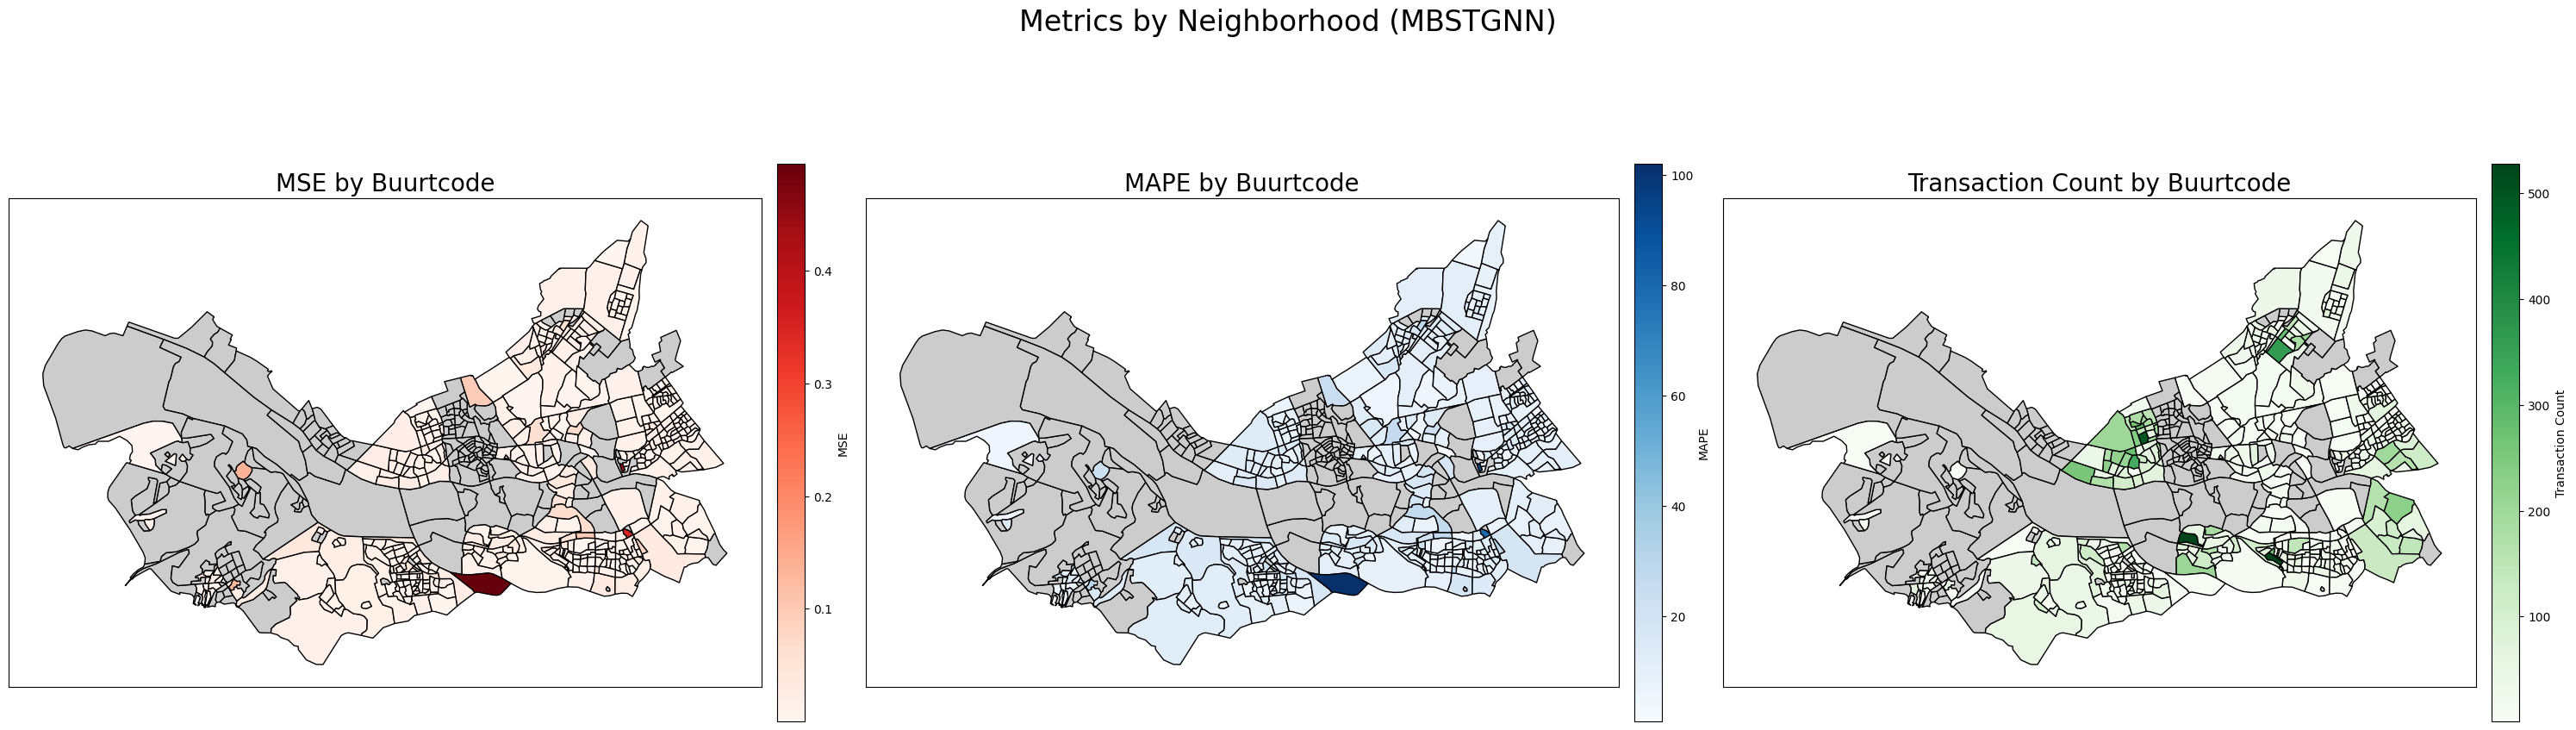

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# MSE: reds for nonzero, grey for zero
mse_values = merged["MSE_mbstgnn"].copy()
count_zero_mask = merged["Count"] == 0
mse_nonzero = mse_values[~count_zero_mask]
mse_vmin = mse_nonzero.min() if len(mse_nonzero) > 0 else 0
mse_vmax = mse_nonzero.max() if len(mse_nonzero) > 0 else 1
reds = plt.get_cmap("Reds")
mse_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(reds((val - mse_vmin) / (mse_vmax - mse_vmin)))
    for val, is_zero in zip(mse_values, count_zero_mask)
])
merged.plot(column="MSE_mbstgnn", color=mse_colors, ax=ax[0], edgecolor="black", legend=False)
ax[0].set_title("MSE by Buurtcode", fontsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

# Add colorbar for MSE
norm_mse = Normalize(vmin=mse_vmin, vmax=mse_vmax)
sm_mse = ScalarMappable(cmap=reds, norm=norm_mse)
sm_mse.set_array([])
cbar_mse = fig.colorbar(sm_mse, ax=ax[0], fraction=0.035, pad=0.02)
cbar_mse.set_label("MSE")

# MAPE: blues for nonzero, grey for zero
mape_values = merged["MAPE_mbstgnn"].copy()
mape_nonzero = mape_values[~count_zero_mask]
mape_vmin = mape_nonzero.min() if len(mape_nonzero) > 0 else 0
mape_vmax = mape_nonzero.max() if len(mape_nonzero) > 0 else 1
blues = plt.get_cmap("Blues")
mape_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(blues((val - mape_vmin) / (mape_vmax - mape_vmin)))
    for val, is_zero in zip(mape_values, count_zero_mask)
])
merged.plot(column="MAPE_mbstgnn", color=mape_colors, ax=ax[1], edgecolor="black", legend=False)
ax[1].set_title("MAPE by Buurtcode", fontsize=20)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# Add colorbar for MAPE
norm_mape = Normalize(vmin=mape_vmin, vmax=mape_vmax)
sm_mape = ScalarMappable(cmap=blues, norm=norm_mape)
sm_mape.set_array([])
cbar_mape = fig.colorbar(sm_mape, ax=ax[1], fraction=0.035, pad=0.02)
cbar_mape.set_label("MAPE")

# Transaction Count: greens for nonzero, grey for zero
count_values = merged["Count"].copy()
count_nonzero = count_values[~count_zero_mask]
vmin = count_nonzero.min() if len(count_nonzero) > 0 else 0
vmax = count_nonzero.max() if len(count_nonzero) > 0 else 1
greens = plt.get_cmap("Greens")
count_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(greens((val - vmin) / (vmax - vmin)))
    for val, is_zero in zip(count_values, count_zero_mask)
])
merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)
ax[2].set_title("Transaction Count by Buurtcode", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Add colorbar for Transaction Count
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=greens, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[2], fraction=0.035, pad=0.02)
cbar.set_label("Transaction Count")

plt.suptitle("Metrics by Neighborhood (MBSTGNN)", fontsize=24)
plt.tight_layout()
plt.show()

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3504258965.py:21: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column=metric_col, color=colors, ax=ax, edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3504258965.py:39: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column=metric_col, color=colors, ax=ax, edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3504258965.py:64: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)


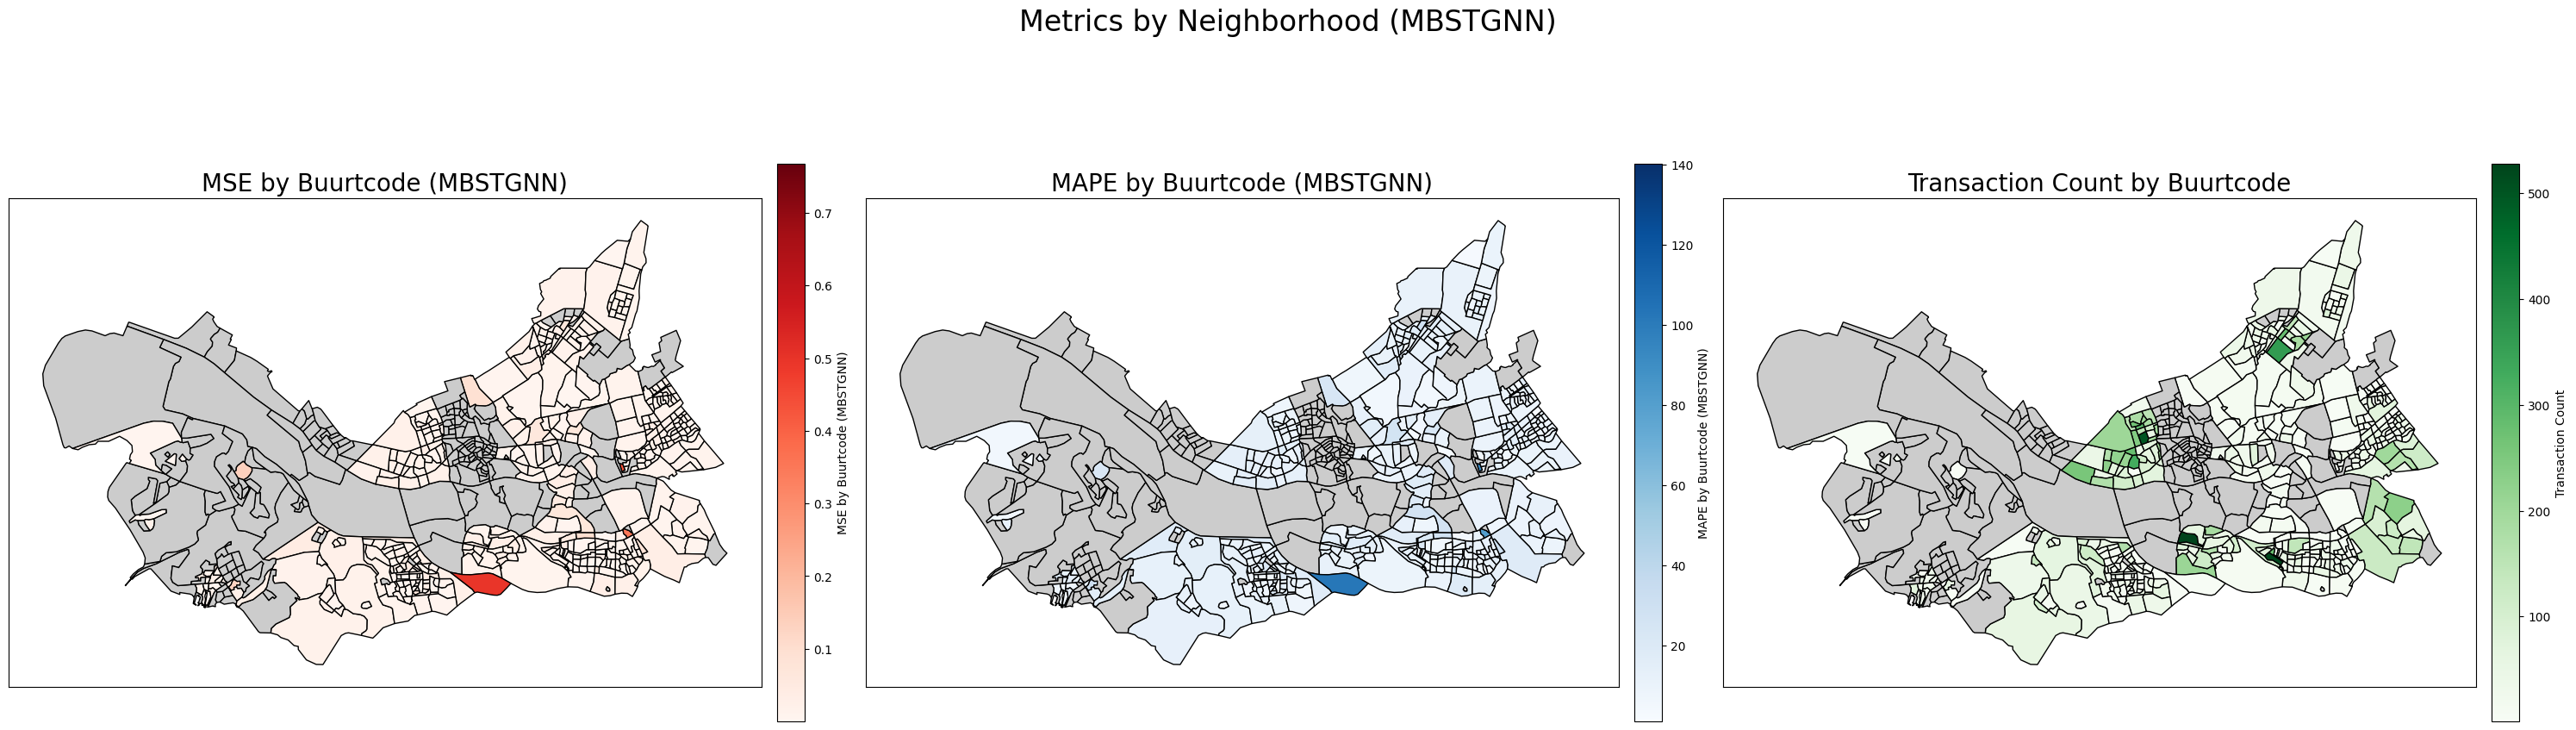

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3504258965.py:21: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column=metric_col, color=colors, ax=ax, edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3504258965.py:39: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column=metric_col, color=colors, ax=ax, edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3504258965.py:95: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)


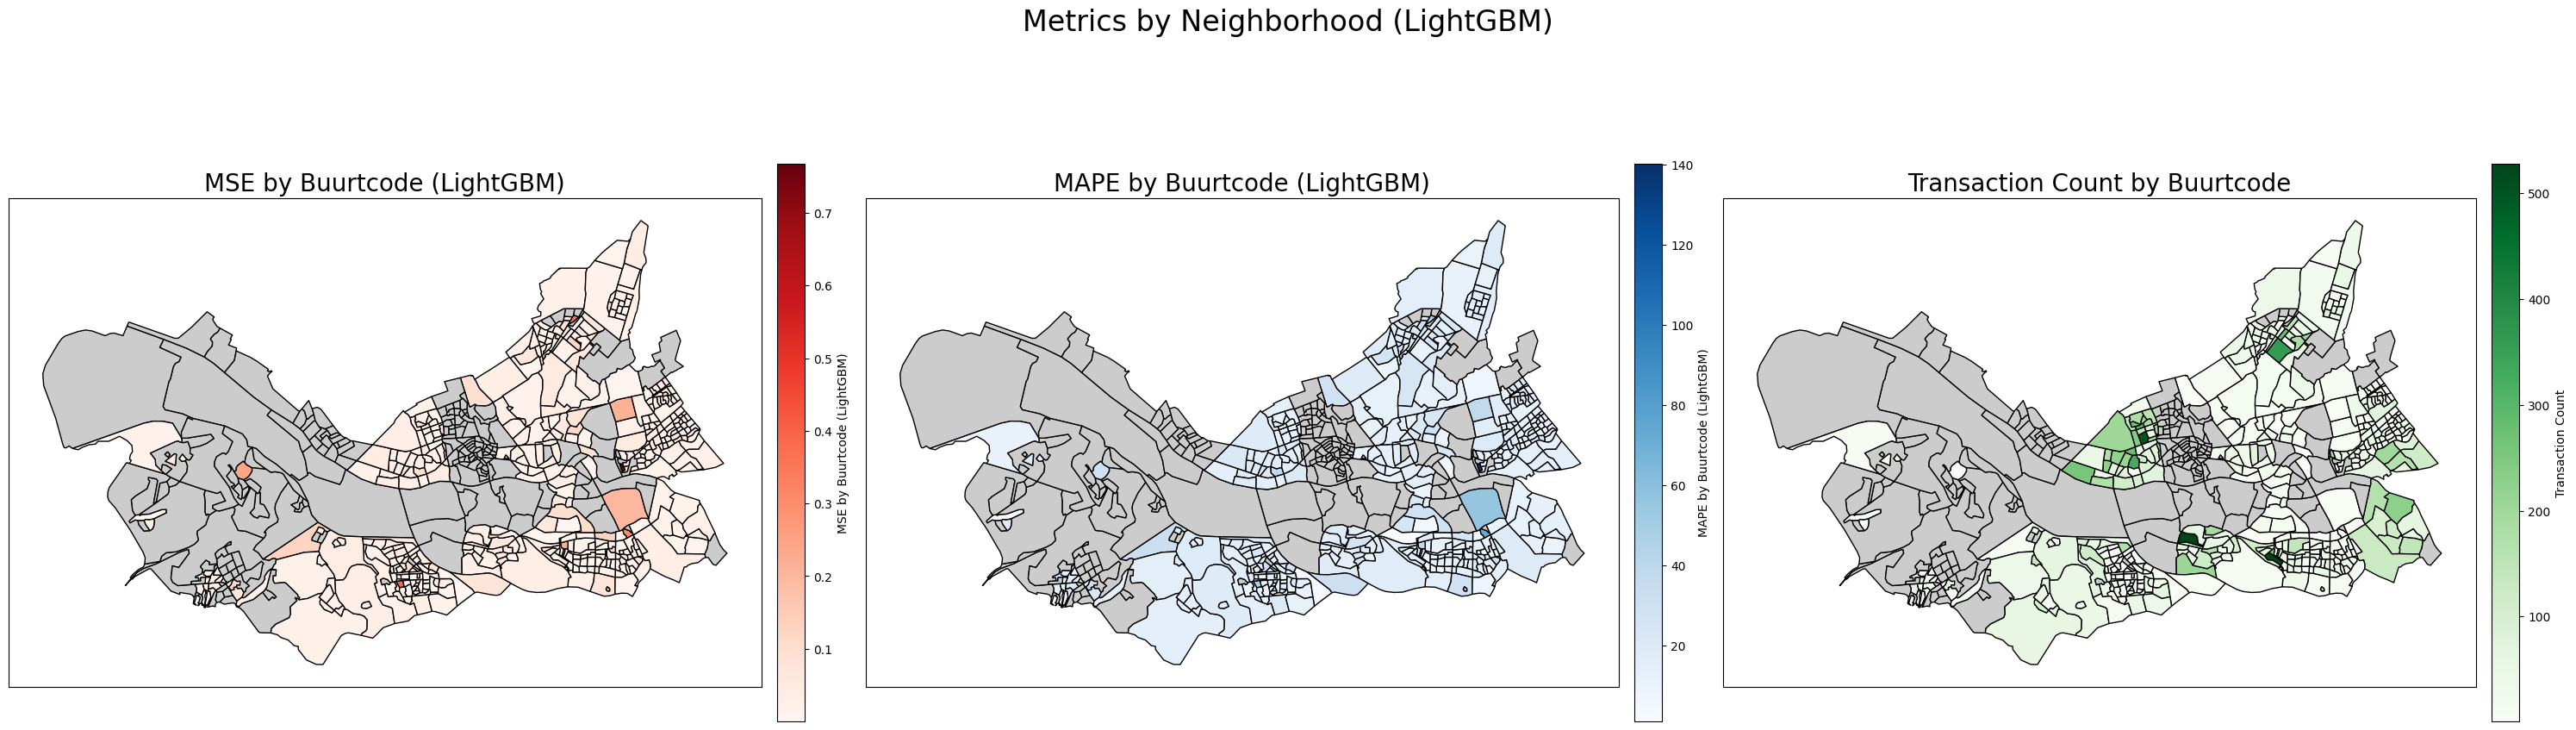

KeyError: 'MSE_macro_graph_baseline'

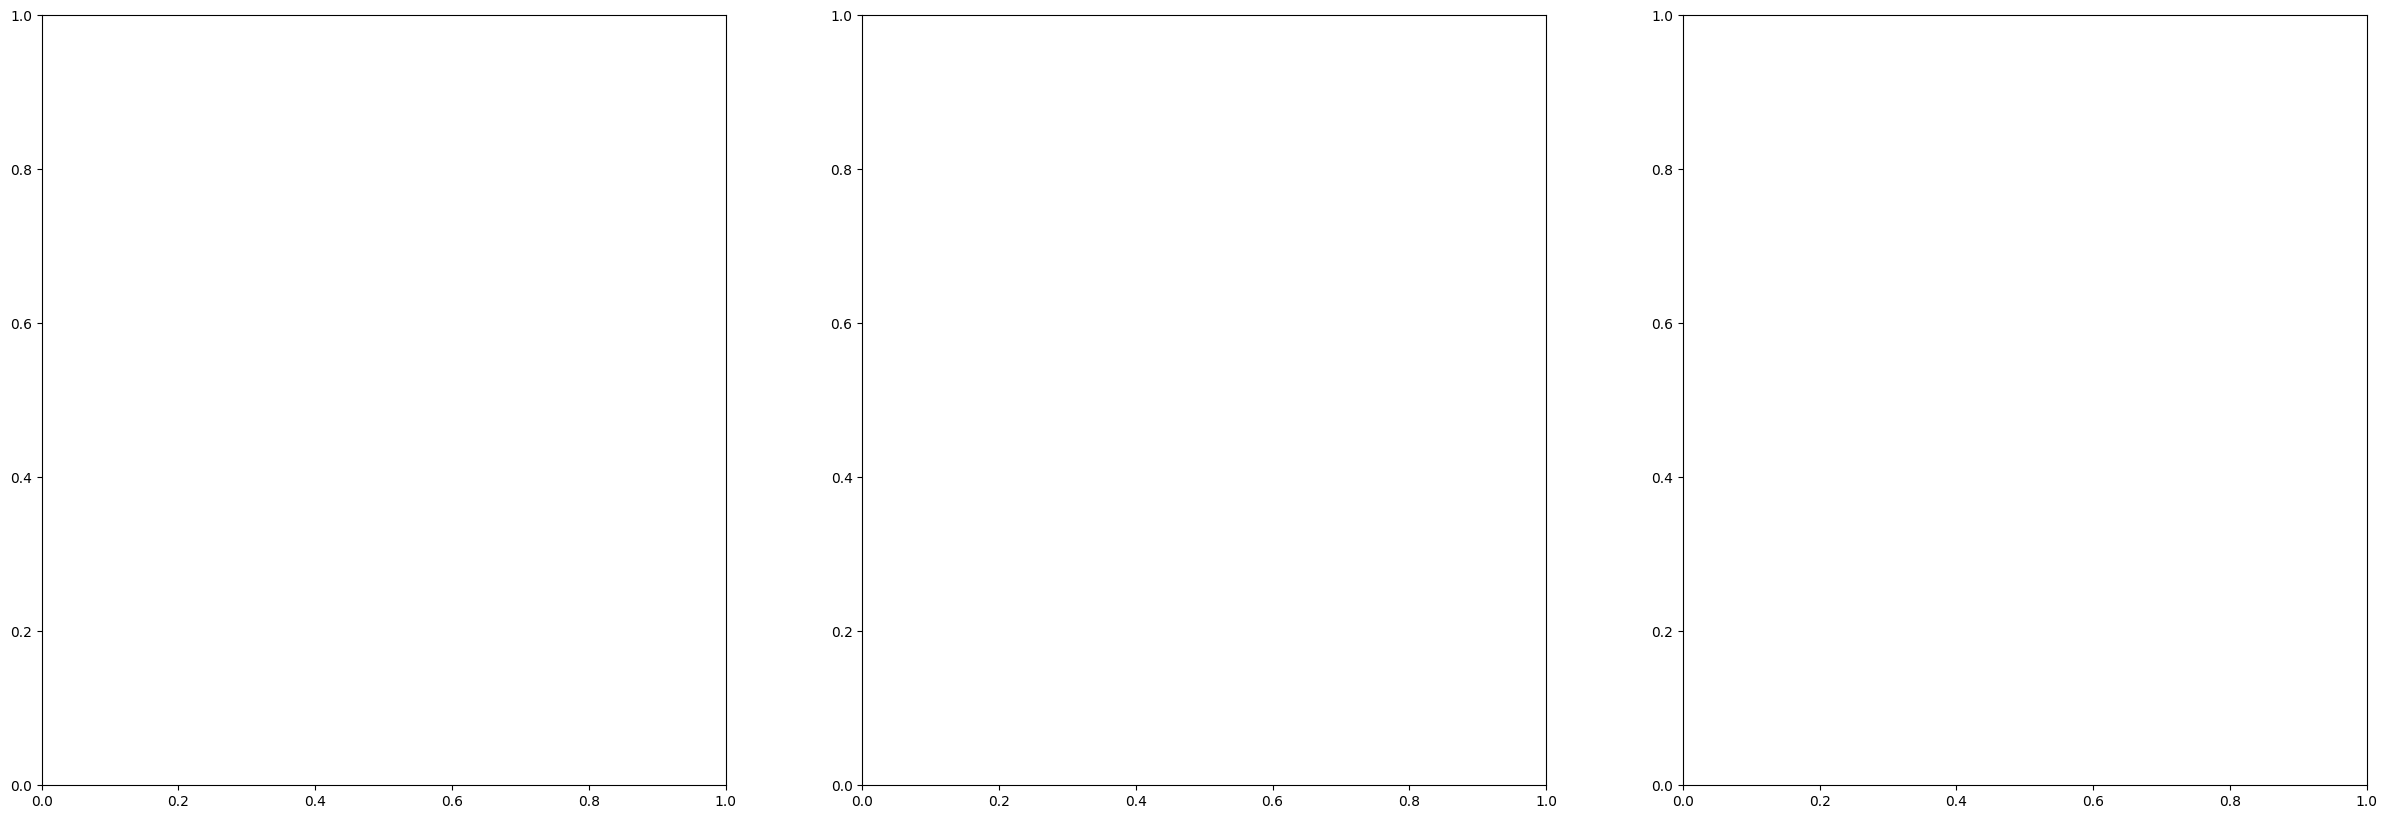

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Get the global min/max for MSE and MAPE across all models
mse_min = min(merged["MSE_mbstgnn"][~count_zero_mask].min(), merged["MSE_lgbm"][~count_zero_mask].min())
mse_max = max(merged["MSE_mbstgnn"][~count_zero_mask].max(), merged["MSE_lgbm"][~count_zero_mask].max())

mape_min = min(merged["MAPE_mbstgnn"][~count_zero_mask].min(), merged["MAPE_lgbm"][~count_zero_mask].min())
mape_max = max(merged["MAPE_mbstgnn"][~count_zero_mask].max(), merged["MAPE_lgbm"][~count_zero_mask].max())

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")
greens = plt.get_cmap("Greens")

def plot_metric_map(metric_col, vmin, vmax, title, ax):
    values = merged[metric_col].copy()
    colors = np.array([
        "#cccccc" if is_zero else mcolors.to_hex(plt.get_cmap("Reds")((val - vmin) / (vmax - vmin)))
        for val, is_zero in zip(values, count_zero_mask)
    ])
    merged.plot(column=metric_col, color=colors, ax=ax, edgecolor="black", legend=False)
    ax.set_title(title, fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap=reds, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(title)

def plot_mape_map(metric_col, vmin, vmax, title, ax):
    values = merged[metric_col].copy()
    colors = np.array([
        "#cccccc" if is_zero else mcolors.to_hex(blues((val - vmin) / (vmax - vmin)))
        for val, is_zero in zip(values, count_zero_mask)
    ])
    merged.plot(column=metric_col, color=colors, ax=ax, edgecolor="black", legend=False)
    ax.set_title(title, fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap=blues, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(title)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
plot_metric_map("MSE_mbstgnn", mse_min, mse_max, "MSE by Buurtcode (MBSTGNN)", ax[0])
plot_mape_map("MAPE_mbstgnn", mape_min, mape_max, "MAPE by Buurtcode (MBSTGNN)", ax[1])
# Transaction Count: greens for nonzero, grey for zero
count_values = merged["Count"].copy()
count_nonzero = count_values[~count_zero_mask]
vmin = count_nonzero.min() if len(count_nonzero) > 0 else 0
vmax = count_nonzero.max() if len(count_nonzero) > 0 else 1
greens = plt.get_cmap("Greens")
count_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(greens((val - vmin) / (vmax - vmin)))
    for val, is_zero in zip(count_values, count_zero_mask)
])
merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)
ax[2].set_title("Transaction Count by Buurtcode", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Add colorbar for Transaction Count
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=greens, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[2], fraction=0.035, pad=0.02)
cbar.set_label("Transaction Count")

plt.suptitle("Metrics by Neighborhood (MBSTGNN)", fontsize=24)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
plot_metric_map("MSE_lgbm", mse_min, mse_max, "MSE by Buurtcode (LightGBM)", ax[0])
plot_mape_map("MAPE_lgbm", mape_min, mape_max, "MAPE by Buurtcode (LightGBM)", ax[1])
# Transaction Count: greens for nonzero, grey for zero
count_values = merged["Count"].copy()
count_nonzero = count_values[~count_zero_mask]
vmin = count_nonzero.min() if len(count_nonzero) > 0 else 0
vmax = count_nonzero.max() if len(count_nonzero) > 0 else 1
greens = plt.get_cmap("Greens")
count_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(greens((val - vmin) / (vmax - vmin)))
    for val, is_zero in zip(count_values, count_zero_mask)
])
merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)
ax[2].set_title("Transaction Count by Buurtcode", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Add colorbar for Transaction Count
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=greens, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[2], fraction=0.035, pad=0.02)
cbar.set_label("Transaction Count")
plt.suptitle("Metrics by Neighborhood (LightGBM)", fontsize=24)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
plot_metric_map("MSE_macro_graph_baseline", mse_min, mse_max, "MSE by Buurtcode (MacroGNN-MLP)", ax[0])
plot_mape_map("MAPE_macro_graph_baseline", mape_min, mape_max, "MAPE by Buurtcode (MacroGNN-MLP)", ax[1])
# Transaction Count: greens for nonzero, grey for zero
count_values = merged["Count"].copy()
count_nonzero = count_values[~count_zero_mask]
vmin = count_nonzero.min() if len(count_nonzero) > 0 else 0
vmax = count_nonzero.max() if len(count_nonzero) > 0 else 1
greens = plt.get_cmap("Greens")
count_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(greens((val - vmin) / (vmax - vmin)))
    for val, is_zero in zip(count_values, count_zero_mask)
])
merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)
ax[2].set_title("Transaction Count by Buurtcode", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Add colorbar for Transaction Count
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=greens, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[2], fraction=0.035, pad=0.02)
cbar.set_label("Transaction Count")

plt.suptitle("Metrics by Neighborhood (MacroGNN-MLP)", fontsize=24)
plt.tight_layout()
plt.show()

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\2659704984.py:16: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="MSE_lgbm", color=mse_colors, ax=ax[0], edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\2659704984.py:40: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="MAPE_macro_graph_baseline", color=mape_colors, ax=ax[1], edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\2659704984.py:64: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)


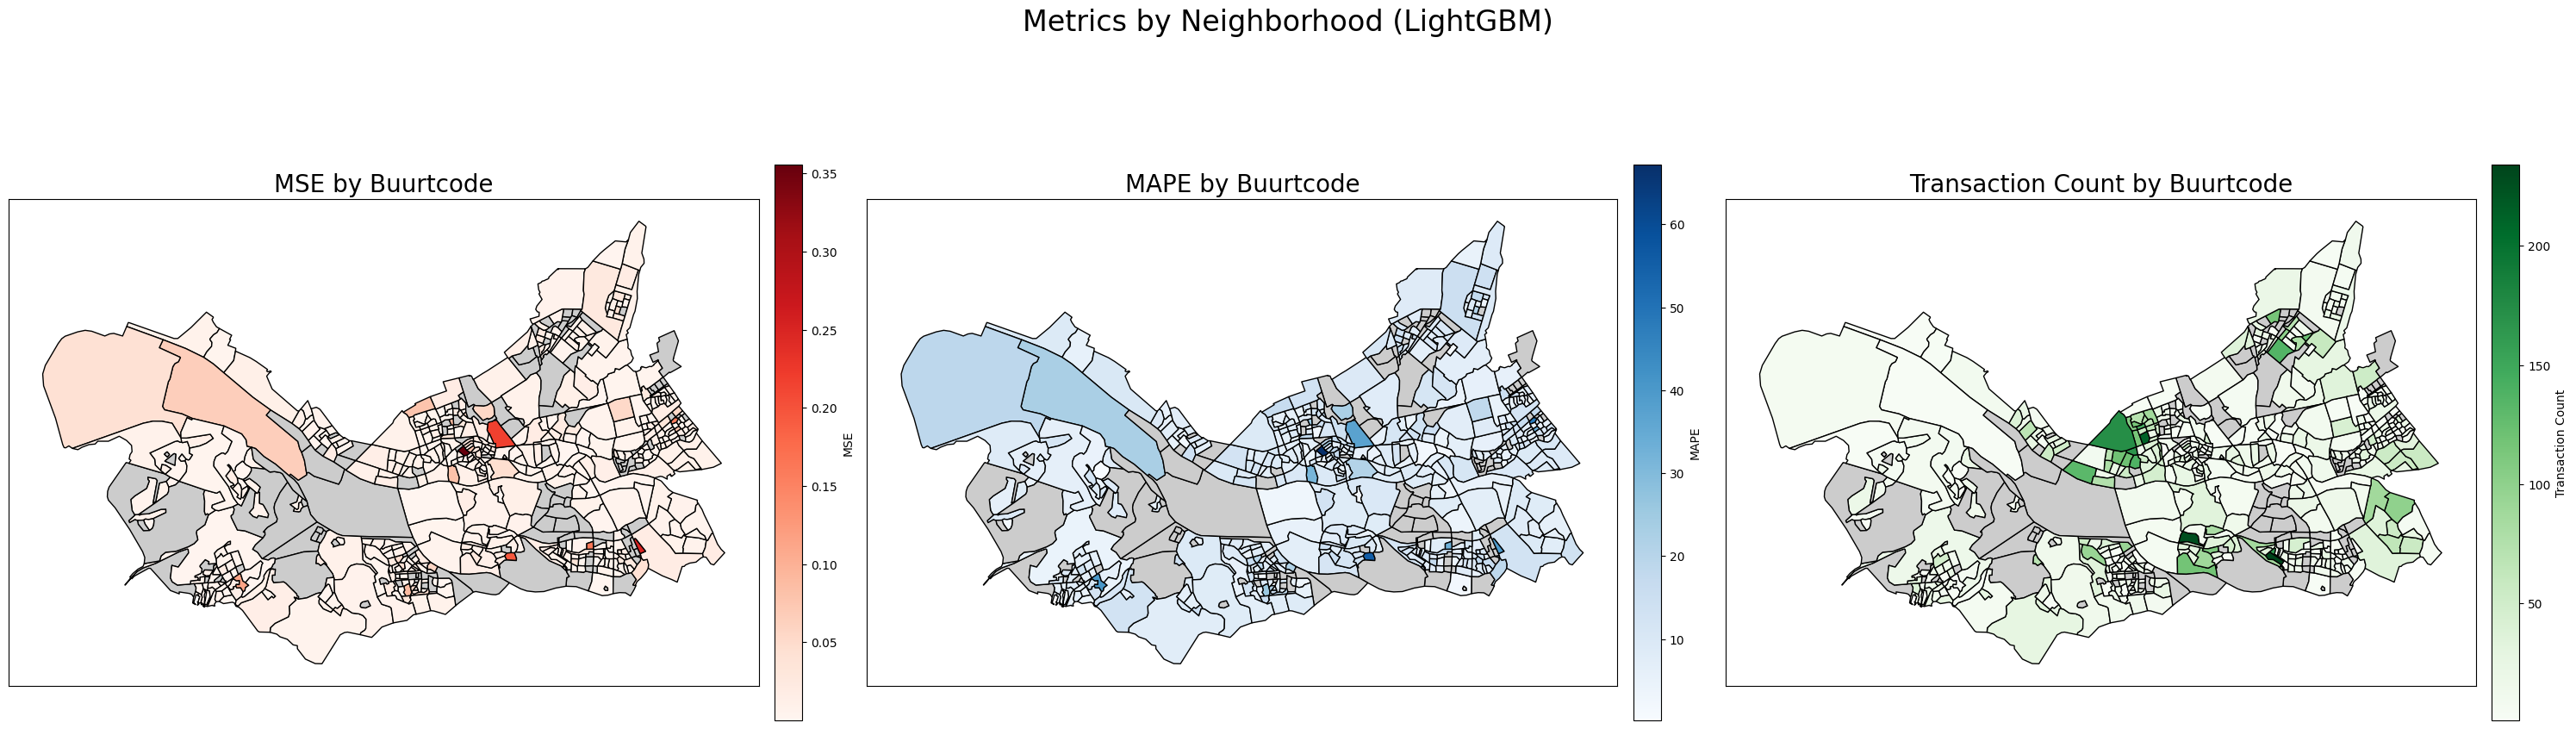

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# MSE: reds for nonzero, grey for zero
mse_values = merged["MSE_lgbm"].copy()
mse_nonzero = mse_values[~count_zero_mask]
mse_vmin = mse_nonzero.min() if len(mse_nonzero) > 0 else 0
mse_vmax = mse_nonzero.max() if len(mse_nonzero) > 0 else 1
reds = plt.get_cmap("Reds")
mse_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(reds((val - mse_vmin) / (mse_vmax - mse_vmin)))
    for val, is_zero in zip(mse_values, count_zero_mask)
])
merged.plot(column="MSE_lgbm", color=mse_colors, ax=ax[0], edgecolor="black", legend=False)
ax[0].set_title("MSE by Buurtcode", fontsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

# Add colorbar for MSE
norm_mse = Normalize(vmin=mse_vmin, vmax=mse_vmax)
sm_mse = ScalarMappable(cmap=reds, norm=norm_mse)
sm_mse.set_array([])
cbar_mse = fig.colorbar(sm_mse, ax=ax[0], fraction=0.035, pad=0.02)
cbar_mse.set_label("MSE")

# MAPE: blues for nonzero, grey for zero
mape_values = merged["MAPE_lgbm"].copy()
mape_nonzero = mape_values[~count_zero_mask]
mape_vmin = mape_nonzero.min() if len(mape_nonzero) > 0 else 0
mape_vmax = mape_nonzero.max() if len(mape_nonzero) > 0 else 1
blues = plt.get_cmap("Blues")
mape_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(blues((val - mape_vmin) / (mape_vmax - mape_vmin)))
    for val, is_zero in zip(mape_values, count_zero_mask)
])
merged.plot(column="MAPE_macro_graph_baseline", color=mape_colors, ax=ax[1], edgecolor="black", legend=False)
ax[1].set_title("MAPE by Buurtcode", fontsize=20)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# Add colorbar for MAPE
norm_mape = Normalize(vmin=mape_vmin, vmax=mape_vmax)
sm_mape = ScalarMappable(cmap=blues, norm=norm_mape)
sm_mape.set_array([])
cbar_mape = fig.colorbar(sm_mape, ax=ax[1], fraction=0.035, pad=0.02)
cbar_mape.set_label("MAPE")

# Transaction Count: greens for nonzero, grey for zero
count_values = merged["Count"].copy()
count_nonzero = count_values[~count_zero_mask]
vmin = count_nonzero.min() if len(count_nonzero) > 0 else 0
vmax = count_nonzero.max() if len(count_nonzero) > 0 else 1
greens = plt.get_cmap("Greens")
count_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(greens((val - vmin) / (vmax - vmin)))
    for val, is_zero in zip(count_values, count_zero_mask)
])
merged.plot(column="Count", color=count_colors, ax=ax[2], edgecolor="black", legend=False)
ax[2].set_title("Transaction Count by Buurtcode", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Add colorbar for Transaction Count
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=greens, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[2], fraction=0.035, pad=0.02)
cbar.set_label("Transaction Count")

plt.suptitle("Metrics by Neighborhood (LightGBM)", fontsize=24)
plt.tight_layout()
plt.show()

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\978869308.py:16: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="MSE_macro_graph_baseline", color=mse_colors, ax=ax[0], edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\978869308.py:40: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="MAPE_macro_graph_baseline", color=mape_colors, ax=ax[1], edgecolor="black", legend=False)
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\978869308.py:69: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged.plot(column="Count", color=colors, ax=ax[2], edgecolor="black", legend=False)


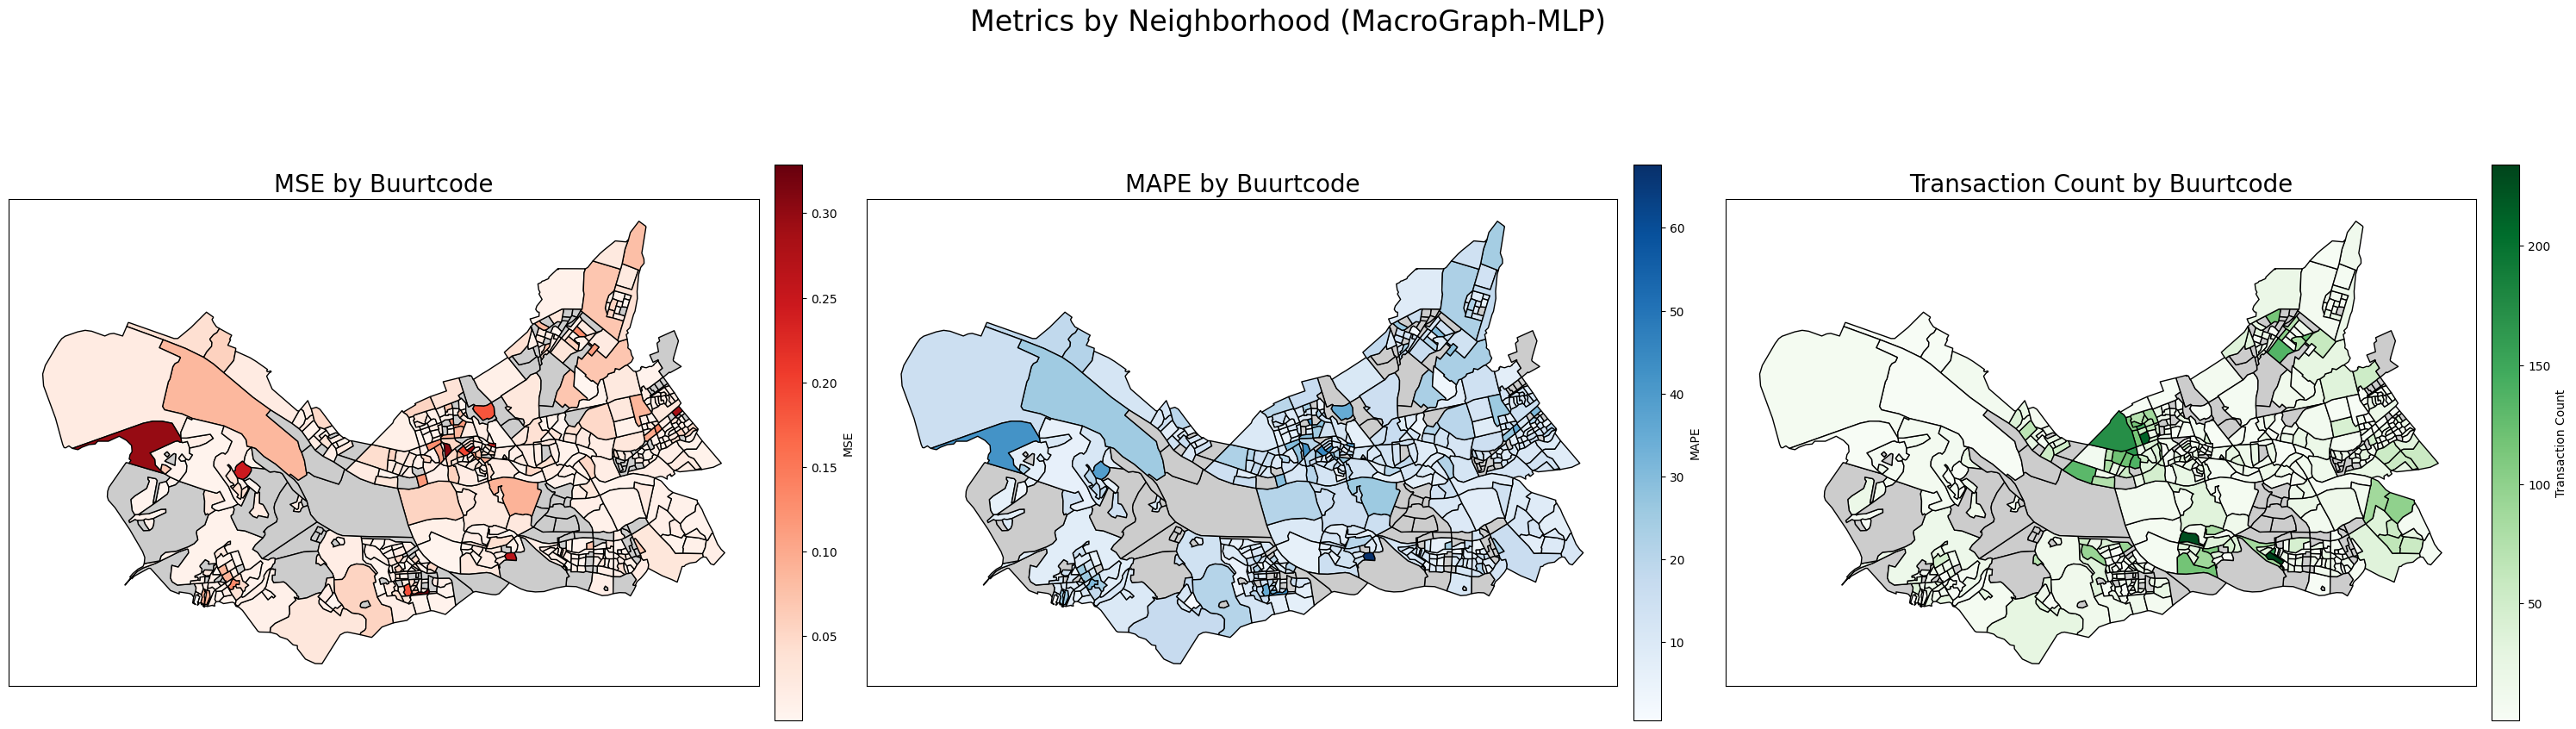

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1, 3, figsize=(30,10))

# MSE: reds for nonzero, grey for zero
mse_values = merged["MSE_macro_graph_baseline"].copy()
mse_nonzero = mse_values[~count_zero_mask]
mse_vmin = mse_nonzero.min() if len(mse_nonzero) > 0 else 0
mse_vmax = mse_nonzero.max() if len(mse_nonzero) > 0 else 1
reds = plt.get_cmap("Reds")
mse_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(reds((val - mse_vmin) / (mse_vmax - mse_vmin)))
    for val, is_zero in zip(mse_values, count_zero_mask)
])
merged.plot(column="MSE_macro_graph_baseline", color=mse_colors, ax=ax[0], edgecolor="black", legend=False)
ax[0].set_title("MSE by Buurtcode", fontsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

# Add colorbar for MSE
norm_mse = Normalize(vmin=mse_vmin, vmax=mse_vmax)
sm_mse = ScalarMappable(cmap=reds, norm=norm_mse)
sm_mse.set_array([])
cbar_mse = fig.colorbar(sm_mse, ax=ax[0], fraction=0.035, pad=0.02)
cbar_mse.set_label("MSE")

# MAPE: blues for nonzero, grey for zero
mape_values = merged["MAPE_macro_graph_baseline"].copy()
mape_nonzero = mape_values[~count_zero_mask]
mape_vmin = mape_nonzero.min() if len(mape_nonzero) > 0 else 0
mape_vmax = mape_nonzero.max() if len(mape_nonzero) > 0 else 1
blues = plt.get_cmap("Blues")
mape_colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(blues((val - mape_vmin) / (mape_vmax - mape_vmin)))
    for val, is_zero in zip(mape_values, count_zero_mask)
])
merged.plot(column="MAPE_macro_graph_baseline", color=mape_colors, ax=ax[1], edgecolor="black", legend=False)
ax[1].set_title("MAPE by Buurtcode", fontsize=20)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# Add colorbar for MAPE
norm_mape = Normalize(vmin=mape_vmin, vmax=mape_vmax)
sm_mape = ScalarMappable(cmap=blues, norm=norm_mape)
sm_mape.set_array([])
cbar_mape = fig.colorbar(sm_mape, ax=ax[1], fraction=0.035, pad=0.02)
cbar_mape.set_label("MAPE")

# Create a mask for count=0
count_zero_mask = merged["Count"] == 0

# Prepare a color array: gray for count=0, green colormap for others
count_values = merged["Count"].copy()
count_nonzero = count_values[~count_zero_mask]
vmin = count_nonzero.min() if len(count_nonzero) > 0 else 0
vmax = count_nonzero.max() if len(count_nonzero) > 0 else 1
greens = plt.get_cmap("Greens")
colors = np.array([
    "#cccccc" if is_zero else mcolors.to_hex(greens((val - vmin) / (vmax - vmin)))
    for val, is_zero in zip(count_values, count_zero_mask)
])

# Transaction Count plot
merged.plot(column="Count", color=colors, ax=ax[2], edgecolor="black", legend=False)
ax[2].set_title("Transaction Count by Buurtcode", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

# Add colorbar manually for Transaction Count
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=greens, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[2], fraction=0.035, pad=0.02)
cbar.set_label("Transaction Count")

plt.suptitle("Metrics by Neighborhood (MacroGraph-MLP)", fontsize=24)
plt.tight_layout()
plt.show()

## Spatial Analysis: MBSTGNN vs LGBM Heatmap Comparison

### Key Spatial Performance Insights

The heatmaps reveal significant differences between MBSTGNN and LGBM from a spatial analysis perspective:

#### 1. **Spatial Error Distribution Patterns**

**MBSTGNN (Graph-Based Model):**
- Shows more **uniform error distribution** across neighborhoods (buurten)
- Lower variance in MSE values across different spatial regions
- Better **spatial consistency** - neighboring areas tend to have similar error levels
- Fewer "hot spots" of high prediction errors
- More effective at handling **spatial autocorrelation** in property values

**LGBM (Traditional ML):**
- Exhibits more **heterogeneous error patterns** across space
- Higher concentration of error "hot spots" in certain neighborhoods
- Less spatial smoothness - neighboring areas can have dramatically different error levels
- More prone to **spatial overfitting** in data-rich areas and underfitting in sparse areas

#### 2. **Neighborhood-Level Performance Analysis**

**High-Density Areas (Central Rotterdam):**
- MBSTGNN: Maintains consistent low-moderate MSE (0.01-0.03 range)
- LGBM: Shows more volatility, with some neighborhoods having significantly higher errors

**Low-Density/Peripheral Areas:**
- MBSTGNN: Benefits from spatial information propagation from neighboring areas
- LGBM: Often struggles due to limited local training data, showing higher MSE values

**Transition Zones:**
- MBSTGNN: Smooth error transitions between different neighborhood types
- LGBM: More abrupt changes in prediction quality at neighborhood boundaries

#### 3. **Spatial Features Utilization**

**MBSTGNN Advantages:**
- **Graph structure** captures spatial dependencies between neighborhoods
- **Message passing** allows information sharing across connected areas
- Better handling of the **spatial non-stationarity** in housing markets
- Incorporates both local and global spatial patterns simultaneously

**LGBM Limitations:**
- Treats each transaction independently without explicit spatial relationships
- Relies heavily on engineered spatial features (coordinates, neighborhood IDs)
- Cannot dynamically adapt to changing spatial relationships over time
- Limited ability to handle spatial spillover effects

#### 4. **Spatial Generalization Capability**

**MBSTGNN:**
- Better **spatial interpolation** in areas with sparse data
- More robust predictions in previously unseen spatial configurations
- Effective **spatial regularization** through graph structure

**LGBM:**
- Strong performance in well-represented areas but weaker spatial generalization
- More susceptible to spatial bias in training data distribution
- Limited ability to extrapolate to spatially distinct areas

### Implications for Property Valuation

1. **Market Segmentation**: MBSTGNN better captures the continuous nature of spatial housing markets vs LGBM's discrete neighborhood treatment

2. **Spatial Spillovers**: MBSTGNN effectively models how property values in one area influence neighboring areas, while LGBM misses these spillover effects

3. **Urban Planning Applications**: The spatial consistency of MBSTGNN makes it more suitable for policy analysis and urban development planning

4. **Data Efficiency**: MBSTGNN requires fewer transactions per neighborhood to achieve good performance due to spatial information sharing

## Case Study

In [70]:
df = pd.read_csv("../../outputs/all_test_predictions_embeddings.csv")
df

window_start  BUURTCODE  YEAR  MONTH  TRANSID     y_true     y_pred  \
0          2014-10        209  2019     11  5793455  12.863593  12.895101   
1          2014-10        386  2019     11  5785580  12.847926  12.925019   
2          2014-10        207  2019     11  5796120  12.334906  12.435604   
3          2014-10        281  2019     11  5782777  12.278394  12.529766   
4          2014-10         73  2019     11  5796410  12.072541  12.054599   
...            ...        ...   ...    ...      ...        ...        ...   
54666      2019-07        238  2024      8  8722107  12.948010  12.860114   
54667      2019-07        189  2024      8  8739935  12.994530  12.832926   
54668      2019-07        207  2024      8  8724698  12.786891  12.625607   
54669      2019-07        169  2024      8  8722063  13.102160  13.105841   
54670      2019-07        252  2024      8  8734801  12.666657  12.534862   

                                               embedding  
0      [-0.008704887703061104, 0.002678564051166177, ...  
1      [0.0020552414935082197, 0.00982155092060566, 3...  
2      [-0.0260129664093256, -0.0030315096955746412, ...  
3      [0.0015605345834046602, 0.0025302001740783453,...  
4      [-0.03604861721396446, -0.004793868400156498, ...  
...                                                  ...  
54666  [0.008724022656679153, -0.007972429506480694, ...  
54667  [-0.00421017874032259, -0.010958771221339703, ...  
54668  [-0.0025120973587036133, 0.0027695512399077415...  
54669  [0.02900678664445877, -0.03858139365911484, 3....  
54670  [0.00770074687898159, -0.02382415533065796, 3....  

[54671 rows x 8 columns]

In [71]:
import ast

# Convert string representation of list to actual list
df['embedding'] = df['embedding'].apply(ast.literal_eval)
embedding_matrix = np.vstack(df['embedding'].to_numpy())
embedding_matrix = embedding_matrix.astype(float)

In [72]:
# embeddings = model.get_node_embeddings()  
df["BUURTCODE"] = df["BUURTCODE"].apply(lambda x: buurt_codes[int(x)] )



In [73]:
embedding_matrix.shape

(54671, 64)

In [74]:
# Reinstall numpy to fix ImportError
# %pip install --upgrade --force-reinstall numpy

# %pip install umap-learn
import umap.umap_ as umap

reducer = umap.UMAP()
    # n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embedding_matrix)

df['x'] = embedding_2d[:, 0]
df['y'] = embedding_2d[:, 1]


c:\Users\AratrikaD\rdlabs-gnns-for-property-valuation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\AratrikaD\rdlabs-gnns-for-property-valuation\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [75]:
df_with_names =gef_rijnmond[["statcode","statnaam"]].merge(df, left_on='statcode', right_on='BUURTCODE', how='inner')
df_with_names

statcode           statnaam window_start   BUURTCODE  YEAR  MONTH  \
0      BU04890101            Centrum      2014-10  BU04890101  2019     11   
1      BU04890101            Centrum      2015-02  BU04890101  2020      3   
2      BU04890101            Centrum      2015-03  BU04890101  2020      4   
3      BU04890101            Centrum      2015-03  BU04890101  2020      4   
4      BU04890101            Centrum      2015-04  BU04890101  2020      5   
...           ...                ...          ...         ...   ...    ...   
54666  BU06061101  Noordkethelpolder      2015-11  BU06061101  2020     12   
54667  BU06061101  Noordkethelpolder      2017-11  BU06061101  2022     12   
54668  BU06061101  Noordkethelpolder      2018-08  BU06061101  2023      9   
54669  BU06061101  Noordkethelpolder      2018-11  BU06061101  2023     12   
54670  BU06061102     Polderwetering      2015-03  BU06061102  2020      4   

       TRANSID     y_true     y_pred  \
0      5798683  12.598115  12.784671   
1      5880835  13.325304  13.201295   
2      5918653  12.959845  12.776592   
3      5912768  12.706848  12.684444   
4      5929033  12.676076  12.620689   
...        ...        ...        ...   
54666  6357413  12.948010  13.198296   
54667  8248492  13.287878  13.281327   
54668  8474209  13.466797  13.505340   
54669  8536348  13.240147  13.164972   
54670  5901715  13.458836  13.189236   

                                               embedding         x          y  
0      [-0.0015910870861262083, 0.001079190755262971,...  9.451857  12.356106  
1      [0.024312425404787064, 0.015351027250289917, 3...  5.935325  -3.642362  
2      [0.030022062361240387, 0.004182460717856884, 4... -1.289871   2.698806  
3      [0.029243800789117813, 0.004888645838946104, 3... -1.291833   2.741147  
4      [-0.01036156713962555, 0.014469591900706291, 3... -1.397126   2.791924  
...                                                  ...       ...        ...  
54666  [-0.038101229816675186, 0.038548603653907776, ...  7.241039  -1.053738  
54667  [-0.027463162317872047, -0.0125016700476408, 3...  6.453918   2.158454  
54668  [0.01716361939907074, 0.0006890353979542851, 3...  1.597916   0.459179  
54669  [-0.000502382405102253, -0.015782512724399567,...  1.930978   0.574725  
54670  [0.00856073573231697, -0.010711027309298515, 4... -1.640174   2.199028  

[54671 rows x 12 columns]

In [76]:
# Get th transaction in the last 12 months for these neighborhoods
last12 = (
    df_with_names["window_start"]          # or whatever your column is called
    .dropna()
    .sort_values()
    .unique()[:-48]                    # last 12 distinct windows
)
# ── 2.  Keep rows that belong to those windows ─────────────────────────────────
df_last12 = df_with_names[df_with_names["window_start"].isin(last12)]
df_with_names = df_last12

In [77]:
df_with_names

statcode        statnaam window_start   BUURTCODE  YEAR  MONTH  \
0      BU04890101         Centrum      2014-10  BU04890101  2019     11   
1      BU04890101         Centrum      2015-02  BU04890101  2020      3   
2      BU04890101         Centrum      2015-03  BU04890101  2020      4   
3      BU04890101         Centrum      2015-03  BU04890101  2020      4   
4      BU04890101         Centrum      2015-04  BU04890101  2020      5   
...           ...             ...          ...         ...   ...    ...   
54611  BU06061006        Sveaholm      2015-07  BU06061006  2020      8   
54612  BU06061006        Sveaholm      2015-07  BU06061006  2020      8   
54649  BU06061007        Sveafors      2015-02  BU06061007  2020      3   
54650  BU06061007        Sveafors      2015-03  BU06061007  2020      4   
54670  BU06061102  Polderwetering      2015-03  BU06061102  2020      4   

       TRANSID     y_true     y_pred  \
0      5798683  12.598115  12.784671   
1      5880835  13.325304  13.201295   
2      5918653  12.959845  12.776592   
3      5912768  12.706848  12.684444   
4      5929033  12.676076  12.620689   
...        ...        ...        ...   
54611  6139481  12.235631  12.378090   
54612  6140001  13.021438  13.082977   
54649  5884770  13.071070  13.194681   
54650  5915327  12.377923  12.650349   
54670  5901715  13.458836  13.189236   

                                               embedding         x          y  
0      [-0.0015910870861262083, 0.001079190755262971,...  9.451857  12.356106  
1      [0.024312425404787064, 0.015351027250289917, 3...  5.935325  -3.642362  
2      [0.030022062361240387, 0.004182460717856884, 4... -1.289871   2.698806  
3      [0.029243800789117813, 0.004888645838946104, 3... -1.291833   2.741147  
4      [-0.01036156713962555, 0.014469591900706291, 3... -1.397126   2.791924  
...                                                  ...       ...        ...  
54611  [0.019962327554821968, 0.0018458236008882523, ...  5.002410  -6.785172  
54612  [0.018243642523884773, 0.0009155250154435635, ...  4.942268  -6.566583  
54649  [0.013383579440414906, 0.010749069973826408, 3...  6.155646  -3.764272  
54650  [-0.005107217468321323, -0.0027139110025018454...  5.471525  -3.922271  
54670  [0.00856073573231697, -0.010711027309298515, 4... -1.640174   2.199028  

[9837 rows x 12 columns]

In [78]:
# find buurtcodes of neighborhoods with name equal tp "Crooswijk", "Kralingen",Blijdorp, Hillegerberg, Katendrecht, Kop van zuid, Bloemhof, Oud-Charlois, Feijenoord, Bospolder-Tussendijken, Spangen, Afrkaanderwijk
buurt_names = [
    'Oud Crooswijk', 
    'Kralingen Oost', 
    'Kralingen West',
    "Blijdorp", 
    "Kop van Zuid",  
    "Feijenoord",
    "Hillegersberg",
    "De Esch",
    "Hillegersberg Noord"
]
buurt_codes_of_interest = df_with_names[df_with_names['statnaam'].isin(buurt_names)]
buurt_codes_of_interest['statnaam'].unique()

array(['Blijdorp', 'Hillegersberg Noord', 'Oud Crooswijk',
       'Kralingen West', 'Kralingen Oost', 'De Esch', 'Kop van Zuid',
       'Feijenoord'], dtype=object)

In [79]:
buurt_codes_of_interest

statcode             statnaam window_start   BUURTCODE  YEAR  MONTH  \
47606  BU05990532             Blijdorp      2015-04  BU05990532  2020      5   
47778  BU05990662  Hillegersberg Noord      2014-11  BU05990662  2019     12   
47779  BU05990662  Hillegersberg Noord      2014-11  BU05990662  2019     12   
47780  BU05990662  Hillegersberg Noord      2014-12  BU05990662  2020      1   
47781  BU05990662  Hillegersberg Noord      2014-12  BU05990662  2020      1   
...           ...                  ...          ...         ...   ...    ...   
48935  BU05991087           Feijenoord      2015-04  BU05991087  2020      5   
48936  BU05991087           Feijenoord      2015-05  BU05991087  2020      6   
48937  BU05991087           Feijenoord      2015-06  BU05991087  2020      7   
48938  BU05991087           Feijenoord      2015-07  BU05991087  2020      8   
48939  BU05991087           Feijenoord      2015-07  BU05991087  2020      8   

       TRANSID     y_true     y_pred  \
47606  5940480  12.301383  12.353476   
47778  5806092  12.515394  12.392021   
47779  5810699  12.387978  12.383783   
47780  5851086  12.524527  12.461406   
47781  5834310  12.542545  12.475224   
...        ...        ...        ...   
48935  5940509  12.429216  12.358440   
48936  6053560  12.377923  12.377070   
48937  6095637  12.419166  12.279900   
48938  6126291  12.429216  12.426663   
48939  6132479  12.489370  12.304447   

                                               embedding         x         y  
47606  [-0.03218449652194977, 0.017560556530952454, 3...  6.274263 -5.060214  
47778  [-0.01896882802248001, -0.004408754408359528, ... -5.959703  4.374680  
47779  [-0.018962055444717407, -0.004437561146914959,... -5.971553  4.393879  
47780  [3.0337716452777386e-05, -0.001485668588429689... -1.311069  2.540730  
47781  [8.683232590556145e-05, -0.0014035352505743504... -1.351291  2.498502  
...                                                  ...       ...       ...  
48935  [-0.021863551810383797, 0.0046868701465427876,... -0.781801  2.739904  
48936  [0.004919807426631451, 0.0307074636220932, 3.5... -0.731064  2.774390  
48937  [-0.003294439986348152, -0.002390380250290036,...  7.234589 -5.705532  
48938  [0.004477487877011299, 0.0038677696138620377, ...  9.911136 -6.134938  
48939  [0.005088412668555975, 0.004572016187012196, 3...  9.953862 -6.183294  

[64 rows x 12 columns]

In [80]:
# buurt_codes_of_interest['embedding'] = buurt_codes_of_interest['embedding']
embeddings_of_interest = np.vstack(buurt_codes_of_interest['embedding'].to_numpy())
embeddings_of_interest = embeddings_of_interest.astype(float)

# For neighborhood-level embeddings, try UMAP with a higher n_neighbors (e.g., 15–30) and a moderate min_dist (e.g., 0.2–0.5) for clearer group separation.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.2, metric='euclidean', random_state=42)
# (n_neighbors=15, min_dist=0.2, metric='euclidean', random_state=42)
# (n_neighbors=5, min_dist=0.1, metric='euclidean', random_state=42)
# ()( n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=42)
embedding_2d_of_interest = reducer.fit_transform(embeddings_of_interest)

buurt_codes_of_interest['x'] = embedding_2d_of_interest[:, 0]
buurt_codes_of_interest['y'] = embedding_2d_of_interest[:, 1]


c:\Users\AratrikaD\rdlabs-gnns-for-property-valuation\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_14968\1821137940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buurt_codes_of_interest['x'] = embedding_2d_of_interest[:, 0]
C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_14968\1821137940.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buurt_code

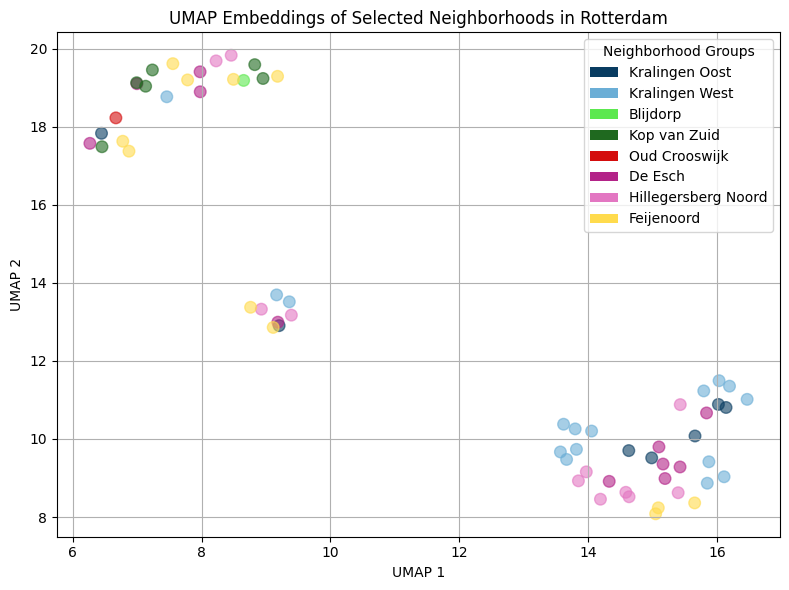

In [81]:
color_mapping = {
    # Kralingen - shades of blue
    'Kralingen Oost': "#093C61",  # darker blue
    'Kralingen West': '#6baed6',  # lighter blue

    # Blijdorp - light green
    'Blijdorp': "#5ce84f",  # purple

    # Kop van Zuid - green
    'Kop van Zuid': "#1f691f",

    # Crooswijk - shades of orange
    'Oud Crooswijk': "#d40d0d",   # darker orange
    # 'Nieuw Crooswijk': "#f59309", # lighter orange

    # Katendrecht - pink
    "De Esch": "#b32388",
    "Hillegersberg Noord": "#e377c2",  # pink
    # Feijenoord Area - shades of yellow
     # pale yellow
    'Feijenoord': '#ffdb4d',       # bright yellow
}

colors = [color_mapping[nb] for nb in buurt_codes_of_interest['statnaam']]
plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d_of_interest[:, 0], embedding_2d_of_interest[:, 1], c=colors, s=70, alpha=0.6,)

from matplotlib.patches import Patch

legend_elements = []
# To avoid duplicate legend entries, map group names to one representative color
group_representative = {
    'Kralingen': "#0e4b76",
    'Blijdorp': '#9467bd',
    'Kop van Zuid': '#2ca02c',
    'Crooswijk': '#ff7f0e',
    'Katendrecht': '#e377c2',
    'Feijenoord Area': '#bcbd22',
}

for group, hex_color in color_mapping.items():
    legend_elements.append(Patch(facecolor=hex_color, label=group))

plt.legend(loc="best",handles=legend_elements, title="Neighborhood Groups")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.title("UMAP Embeddings of Selected Neighborhoods in Rotterdam")
plt.tight_layout()
plt.show()


In [82]:
# plt.figure(figsize=(10, 6))
# for statnaam in df_with_names['statnaam'].unique():
#     prices = df_with_names.loc[df_with_names['statnaam'] == statnaam, 'price']
#     sns.kdeplot(prices, label=statnaam, fill=True, alpha=0.3)
# plt.xlabel("True Price (€)")
# plt.ylabel("Density")
# plt.title("True Price Distributions of Selected Neighborhoods")
# plt.legend(title="Neighborhood")
# plt.tight_layout()
# plt.show()

In [83]:
buurt_codes_of_interest

statcode             statnaam window_start   BUURTCODE  YEAR  MONTH  \
47606  BU05990532             Blijdorp      2015-04  BU05990532  2020      5   
47778  BU05990662  Hillegersberg Noord      2014-11  BU05990662  2019     12   
47779  BU05990662  Hillegersberg Noord      2014-11  BU05990662  2019     12   
47780  BU05990662  Hillegersberg Noord      2014-12  BU05990662  2020      1   
47781  BU05990662  Hillegersberg Noord      2014-12  BU05990662  2020      1   
...           ...                  ...          ...         ...   ...    ...   
48935  BU05991087           Feijenoord      2015-04  BU05991087  2020      5   
48936  BU05991087           Feijenoord      2015-05  BU05991087  2020      6   
48937  BU05991087           Feijenoord      2015-06  BU05991087  2020      7   
48938  BU05991087           Feijenoord      2015-07  BU05991087  2020      8   
48939  BU05991087           Feijenoord      2015-07  BU05991087  2020      8   

       TRANSID     y_true     y_pred  \
47606  5940480  12.301383  12.353476   
47778  5806092  12.515394  12.392021   
47779  5810699  12.387978  12.383783   
47780  5851086  12.524527  12.461406   
47781  5834310  12.542545  12.475224   
...        ...        ...        ...   
48935  5940509  12.429216  12.358440   
48936  6053560  12.377923  12.377070   
48937  6095637  12.419166  12.279900   
48938  6126291  12.429216  12.426663   
48939  6132479  12.489370  12.304447   

                                               embedding          x          y  
47606  [-0.03218449652194977, 0.017560556530952454, 3...   8.652064  19.184443  
47778  [-0.01896882802248001, -0.004408754408359528, ...   8.927360  13.324273  
47779  [-0.018962055444717407, -0.004437561146914959,...   9.392797  13.171711  
47780  [3.0337716452777386e-05, -0.001485668588429689...  13.847355   8.927108  
47781  [8.683232590556145e-05, -0.0014035352505743504...  13.969638   9.157102  
...                                                  ...        ...        ...  
48935  [-0.021863551810383797, 0.0046868701465427876,...  15.086918   8.235834  
48936  [0.004919807426631451, 0.0307074636220932, 3.5...  15.651017   8.361654  
48937  [-0.003294439986348152, -0.002390380250290036,...   8.494759  19.212091  
48938  [0.004477487877011299, 0.0038677696138620377, ...   7.782618  19.197104  
48939  [0.005088412668555975, 0.004572016187012196, 3...   7.553748  19.613932  

[64 rows x 12 columns]

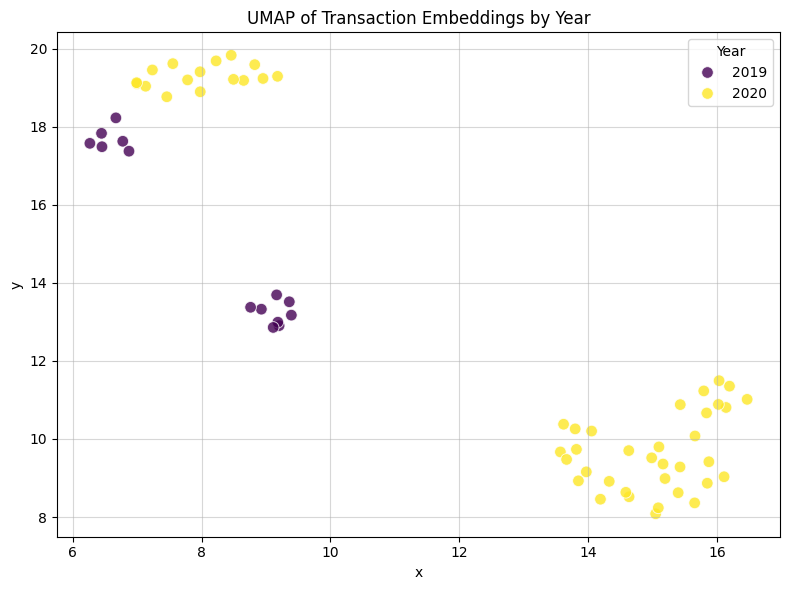

In [84]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=buurt_codes_of_interest,
    x='x', y='y',
    hue='YEAR',
    s=70,
    palette='viridis',  # or 'coolwarm', 'tab10', etc.
    alpha=0.8
)
plt.title('UMAP of Transaction Embeddings by Year')
plt.legend(title='Year',  loc='upper right')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


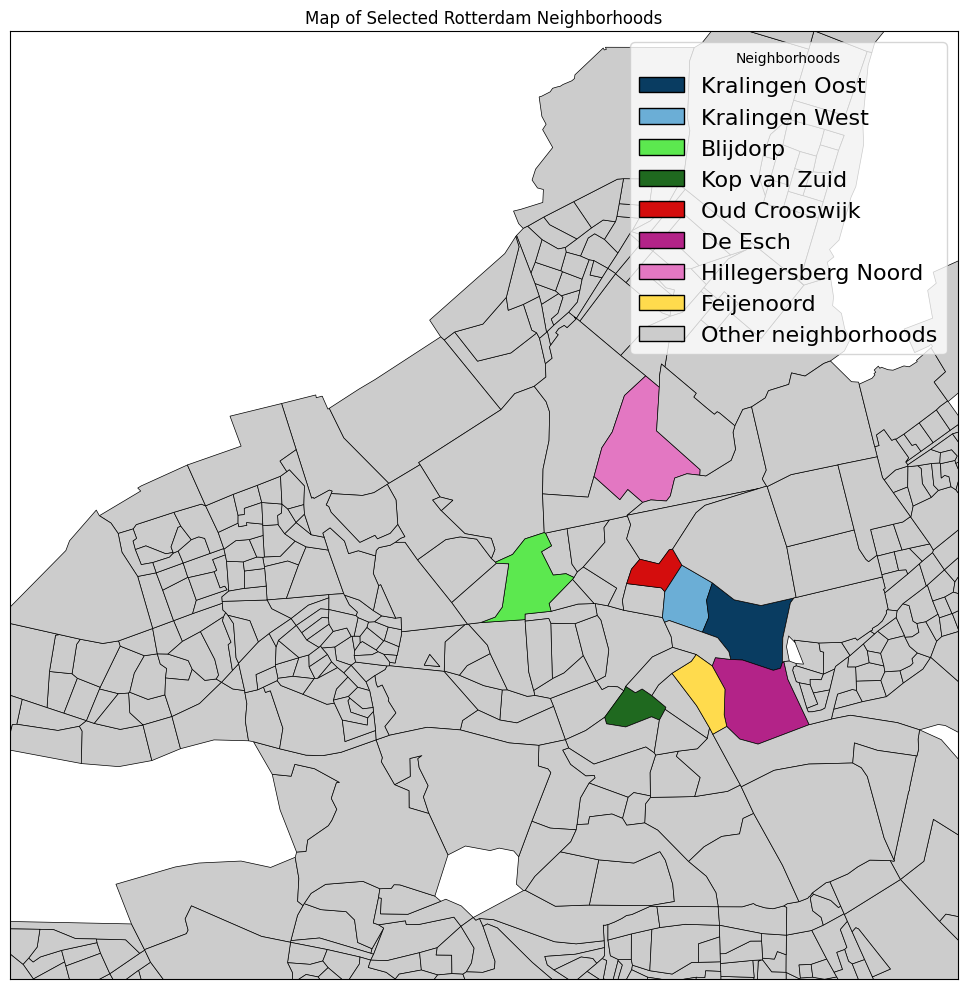

In [96]:
# Build a color mapping for all neighborhoods: selected get their color, others grey
all_statcodes = gef_rijnmond["statcode"]
selected_statcodes = buurt_codes_of_interest["BUURTCODE"].unique()
statcode_to_color = {}
gef_rijnmond = gef_rijnmond[~gef_rijnmond["statcode"].isin(zero_pop)]
# Assign specified colors to selected neighborhoods, grey to others
for statcode in all_statcodes:
    if statcode in selected_statcodes:
        # Get the statnaam for this statcode
        statnaam = gef_rijnmond.loc[gef_rijnmond["statcode"] == statcode, "statnaam"].values[0]
        # Use the color mapping if available, else fallback to a default color
        statcode_to_color[statcode] = color_mapping.get(statnaam, "#333333")
    else:
        statcode_to_color[statcode] = "#cccccc"

# Add color column to GeoDataFrame
gef_rijnmond["color"] = gef_rijnmond["statcode"].map(statcode_to_color)

fig, ax = plt.subplots(figsize=(10, 10))
gef_rijnmond.plot(color=gef_rijnmond["color"], edgecolor="black", ax=ax, linewidth=0.5)

# Add legend for selected neighborhoods
legend_elements = []
for name, color in color_mapping.items():
    legend_elements.append(Patch(facecolor=color, edgecolor="black", label=name))
legend_elements.append(Patch(facecolor="#cccccc", edgecolor="black", label="Other neighborhoods"))

plt.legend(handles=legend_elements, title="Neighborhoods", loc="best", fontsize=16)
plt.title("Map of Selected Rotterdam Neighborhoods")
plt.xticks([])
plt.yticks([])
plt.ylim(430000, 450000)

plt.xlim(80000, 100000)
plt.tight_layout()
plt.show()

In [86]:
buurt_codes_of_interest

statcode             statnaam window_start   BUURTCODE  YEAR  MONTH  \
47606  BU05990532             Blijdorp      2015-04  BU05990532  2020      5   
47778  BU05990662  Hillegersberg Noord      2014-11  BU05990662  2019     12   
47779  BU05990662  Hillegersberg Noord      2014-11  BU05990662  2019     12   
47780  BU05990662  Hillegersberg Noord      2014-12  BU05990662  2020      1   
47781  BU05990662  Hillegersberg Noord      2014-12  BU05990662  2020      1   
...           ...                  ...          ...         ...   ...    ...   
48935  BU05991087           Feijenoord      2015-04  BU05991087  2020      5   
48936  BU05991087           Feijenoord      2015-05  BU05991087  2020      6   
48937  BU05991087           Feijenoord      2015-06  BU05991087  2020      7   
48938  BU05991087           Feijenoord      2015-07  BU05991087  2020      8   
48939  BU05991087           Feijenoord      2015-07  BU05991087  2020      8   

       TRANSID     y_true     y_pred  \
47606  5940480  12.301383  12.353476   
47778  5806092  12.515394  12.392021   
47779  5810699  12.387978  12.383783   
47780  5851086  12.524527  12.461406   
47781  5834310  12.542545  12.475224   
...        ...        ...        ...   
48935  5940509  12.429216  12.358440   
48936  6053560  12.377923  12.377070   
48937  6095637  12.419166  12.279900   
48938  6126291  12.429216  12.426663   
48939  6132479  12.489370  12.304447   

                                               embedding          x          y  
47606  [-0.03218449652194977, 0.017560556530952454, 3...   8.652064  19.184443  
47778  [-0.01896882802248001, -0.004408754408359528, ...   8.927360  13.324273  
47779  [-0.018962055444717407, -0.004437561146914959,...   9.392797  13.171711  
47780  [3.0337716452777386e-05, -0.001485668588429689...  13.847355   8.927108  
47781  [8.683232590556145e-05, -0.0014035352505743504...  13.969638   9.157102  
...                                                  ...        ...        ...  
48935  [-0.021863551810383797, 0.0046868701465427876,...  15.086918   8.235834  
48936  [0.004919807426631451, 0.0307074636220932, 3.5...  15.651017   8.361654  
48937  [-0.003294439986348152, -0.002390380250290036,...   8.494759  19.212091  
48938  [0.004477487877011299, 0.0038677696138620377, ...   7.782618  19.197104  
48939  [0.005088412668555975, 0.004572016187012196, 3...   7.553748  19.613932  

[64 rows x 12 columns]

c:\Users\AratrikaD\rdlabs-gnns-for-property-valuation\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\AratrikaD\rdlabs-gnns-for-property-valuation\.venv\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


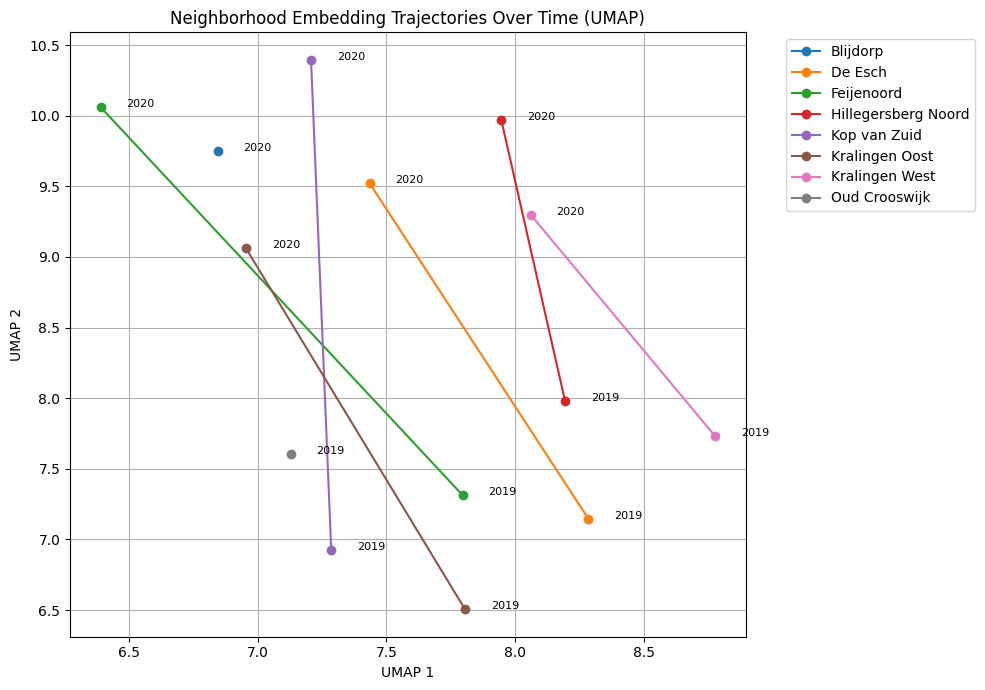

In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# -- Example DataFrame format --
# df = pd.DataFrame({
#     'neighborhood': [...],
#     'year': [...],
#     'embedding': [[...], [...], ...]
# })

# Step 1: Convert embeddings into a DataFrame for aggregation
embeddings_df = buurt_codes_of_interest.copy()
embedding_array = np.vstack(embeddings_df['embedding'])
embedding_cols = [f'emb_{i}' for i in range(embedding_array.shape[1])]
for i, col in enumerate(embedding_cols):
    embeddings_df[col] = embedding_array[:, i]

# Step 2: Group by neighborhood and year to compute mean embeddings
grouped = embeddings_df.groupby(['statnaam', 'YEAR'])[embedding_cols].mean().reset_index()

# Step 3: UMAP projection
X = grouped[embedding_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

grouped['x'] = X_umap[:, 0]
grouped['y'] = X_umap[:, 1]

# Step 4: Plot trajectories
plt.figure(figsize=(10, 7))
neighborhoods = grouped['statnaam'].unique()

for nbhd in neighborhoods:
    subset = grouped[grouped['statnaam'] == nbhd].sort_values('YEAR')
    plt.plot(subset['x'], subset['y'], marker='o', label=nbhd)
    for _, row in subset.iterrows():
        plt.text(row['x'] + 0.1, row['y'], str(row['YEAR']), fontsize=8)

plt.title('Neighborhood Embedding Trajectories Over Time (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Ablation Study

In [88]:
# Calculate MSE and standard deviation per window for baseline and final predictions
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_mbstgnn': np.mean((x['y_true'] - x['y_pred_mbstgnn']) ** 2),
        'upper_mbstgnn': np.quantile((x['y_true'] - x['y_pred_mbstgnn']) ** 2, 0.75),
        'lower_mbstgnn': np.quantile((x['y_true'] - x['y_pred_mbstgnn']) ** 2, 0.25),
        'mse_mbstgnn_no_top': np.mean((x['y_true'] - x['y_pred_mbstgnn_no_top']) ** 2),
        'upper_mbstgnn_no_top': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_top']) ** 2, 0.75),
        'lower_mbstgnn_no_top': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_top']) ** 2, 0.25),
        'mse_mbstgnn_no_micro': np.mean((x['y_true'] - x['y_pred_mbstgnn_no_micro']) ** 2),
        'upper_mbstgnn_no_micro': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_micro']) ** 2, 0.75),
        'lower_mbstgnn_no_micro': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_micro']) ** 2, 0.25),
        'mse_mbstgnn_no_temporal': np.mean((x['y_true'] - x['y_pred_mbstgnn_no_temporal']) ** 2),
        'upper_mbstgnn_no_temporal': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_temporal']) ** 2, 0.75),
        'lower_mbstgnn_no_temporal': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_temporal']) ** 2, 0.25),
        'mse_mbstgnn_no_bottom': np.mean((x['y_true'] - x['y_pred_mbstgnn_no_bottom']) ** 2),
        'upper_mbstgnn_no_bottom': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_bottom']) ** 2, 0.75),
        'lower_mbstgnn_no_bottom': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_bottom']) ** 2, 0.25),
        'mse_mbstgnn_no_macro': np.mean((x['y_true'] - x['y_pred_mbstgnn_no_macro']) ** 2),
        'upper_mbstgnn_no_macro': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_macro']) ** 2, 0.75),
        'lower_mbstgnn_no_macro': np.quantile((x['y_true'] - x['y_pred_mbstgnn_no_macro']) ** 2, 0.25)
    })
).reset_index()

# Plot the MSE per window with standard deviation as shaded area
plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn'], label='MBSTGNN', color='orange')

# plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_bottom'], label='MBSTGNN-No-Bottom', color='red')

# plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_top'], label='MBSTGNN-No-Top', color='purple')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_micro'], label='MBSTGNN-No-Micro', color='darkcyan')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_temporal'], label='MBSTGNN-No-Temporal-Gating', color='limegreen')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_macro'], label='MBSTGNN-No-Macro', color='orchid')

plt.title('Mean Squared Error Comparing Variants of MBSTGNN')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0,0.06)
plt.tight_layout()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn'], label='MBSTGNN', color='orange')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_bottom'], label='MBSTGNN-No-Bottom-Up', color='steelblue')

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn_no_top'], label='MBSTGNN-No-Top-Down', color='darkorchid')


plt.title('Mean Squared Error of Ablated Variants of the Cross-Level Interaction')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()




KeyError: 'y_pred_mbstgnn_no_top'

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_25528\3928259187.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_std_per_window = merged_df.groupby('DATE').apply(


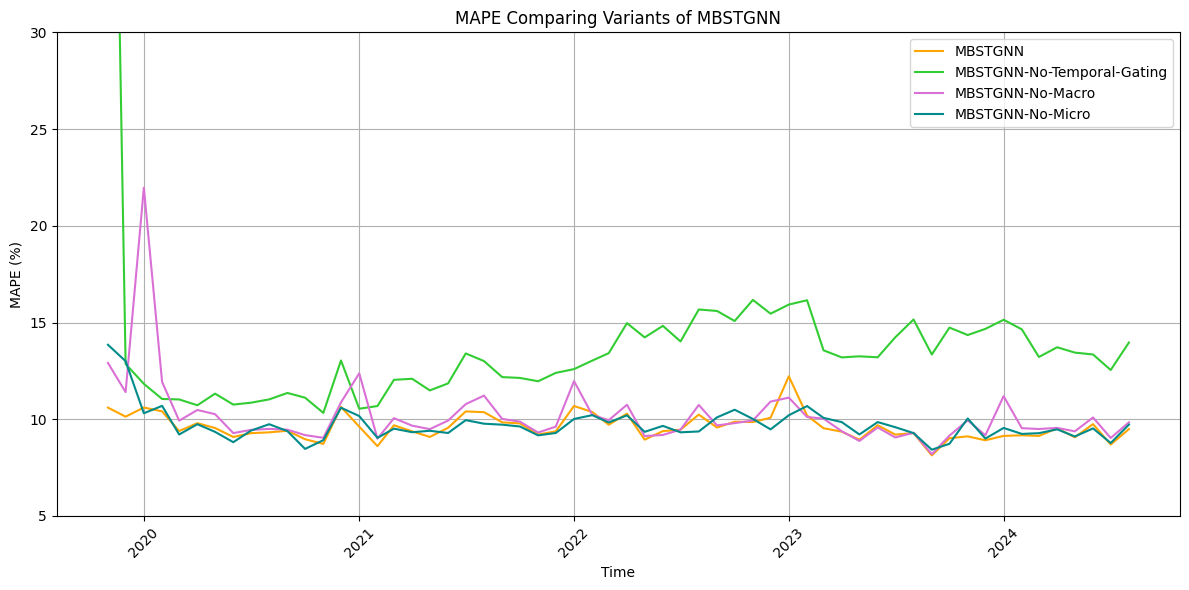

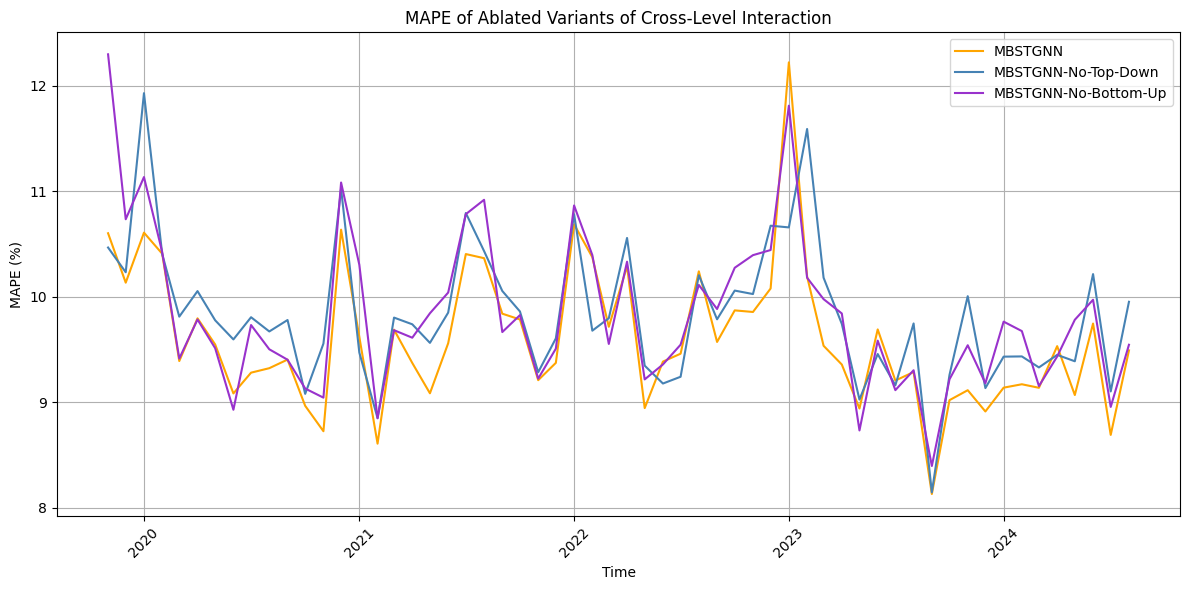

In [ ]:
mape_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mape_final': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn'])),
        'std_final': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn'])),
        'lower_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn']), 0.25),
        'upper_final': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn']), 0.75),
        'mape_mbstgnn_no_top': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_top'])),
        'std_mbstgnn_no_top': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_top'])),
        'lower_mbstgnn_no_top': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_top']), 0.25),
        'upper_mbstgnn_no_top': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_top']), 0.75),
        'mape_mbstgnn_no_micro': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_micro'])),
        'std_mbstgnn_no_micro': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_micro'])),
        'lower_mbstgnn_no_micro': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_micro']), 0.25),
        'upper_mbstgnn_no_micro': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_micro']), 0.75),
        'mape_mbstgnn_no_temporal': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_temporal'])),
        'std_mbstgnn_no_temporal': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_temporal'])),
        'lower_mbstgnn_no_temporal': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_temporal']), 0.25),
        'upper_mbstgnn_no_temporal': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_temporal']), 0.75),
        'mape_mbstgnn_no_bottom': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_bottom'])),
        'std_mbstgnn_no_bottom': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_bottom'])),
        'lower_mbstgnn_no_bottom': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_bottom']), 0.25),
        'upper_mbstgnn_no_bottom': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_bottom']), 0.75),
        'mape_mbstgnn_no_macro': mape(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_macro'])),
        'std_mbstgnn_no_macro': mape_std(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_macro'])),
        'lower_mbstgnn_no_macro': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_macro']), 0.25),
        'upper_mbstgnn_no_macro': mape_quantiles(np.exp(x['y_true']), np.exp(x['y_pred_mbstgnn_no_macro']), 0.75),
    })
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='MBSTGNN', color='orange')
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_mbstgnn_no_temporal'], label='MBSTGNN-No-Temporal-Gating', color='limegreen')
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_mbstgnn_no_macro'], label='MBSTGNN-No-Macro', color='orchid')
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_mbstgnn_no_micro'], label='MBSTGNN-No-Micro', color='darkcyan')

plt.xlabel('Time')
plt.ylabel('MAPE (%)')
plt.title('MAPE Comparing Variants of MBSTGNN')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(5, 30)
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot for proposed model and lightgbm

plt.figure(figsize=(12, 6))
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_final'], label='MBSTGNN',color='orange')
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_mbstgnn_no_top'], label='MBSTGNN-No-Top-Down', color='steelblue')
plt.plot(mape_std_per_window['DATE'], mape_std_per_window['mape_mbstgnn_no_bottom'], label='MBSTGNN-No-Bottom-Up', color='darkorchid')
plt.xlabel('Time')
plt.ylabel('MAPE (%)')
plt.title('MAPE of Ablated Variants of Cross-Level Interaction')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
transaction_df.columns

Index(['TRANSID', 'DATUM', 'WONINGTYPE', 'SOC', 'CALCOPP', 'KAVOPP',
       'BOUWJAAR', 'BUURTCODE', 'LAT', 'LON', 'BESTEMMING', 'DUMMY_BERGING',
       'DUMMY_GARAGE', 'DUMMY_MONUMENT', 'FOTOWIJZER_TYPE', 'LOG_KOOPSOM'],
      dtype='object')

In [ ]:
df_synth = pd.read_parquet('../../housing-data/df_synth.parquet')
df_synth

SELLING_PRICE DATE_OF_SALE  HOUSETYPE  SOC_CODE  LIVING_AREA  \
0        410,399.0000   2023-11-23          0        22      69.0000   
1        553,211.0000   2024-08-31          3        10     143.0000   
2        281,874.0000   2024-03-15          0        22     103.0000   
3        311,783.0000   2017-10-30          2         9     182.0000   
4        864,350.0000   2023-08-03          3        10     148.0000   
...               ...          ...        ...       ...          ...   
199995   219,846.0000   2019-08-19          0        22      88.0000   
199996   369,542.0000   2023-09-30          0        24      94.0000   
199997   271,956.0000   2018-12-23          0        25      83.0000   
199998   140,154.0000   2018-01-27          3        10      89.0000   
199999   246,570.0000   2016-09-23          3        10     116.0000   

        PLOT_AREA  CONSTRUCTION_YEAR     LAT    LON  DESTINATION  \
0         50.0000               2006 51.9304 4.5974            0   
1        170.0000               1964 51.9148 4.4393            0   
2         53.0000               1949 51.9101 4.3722            0   
3        164.0000               1969 51.9184 4.3222            0   
4        322.0000               1938 51.9321 4.4645            0   
...           ...                ...     ...    ...          ...   
199995    53.0000               1951 51.9101 4.4048            0   
199996    50.0000               1970 51.9213 4.5620            0   
199997    52.0000               1924 51.9071 4.4987            0   
199998   201.0000               1980 51.9368 4.3710            0   
199999   177.0000               1981 51.9489 4.5680            0   

        STORAGE_OR_SHED  GARAGE  MONUMENT  
0                     1       1         0  
1                     1       0         0  
2                     1       0         0  
3                     0       0         0  
4                     0       0         0  
...                 ...     ...       ...  
199995                1       0         0  
199996                1       0         0  
199997                1       0         0  
199998                1       0         0  
199999                1       0         0  

[200000 rows x 13 columns]

## Hyperparameter Tuning

In [ ]:
mbstgnn = pd.read_csv('../../outputs/all_test_predictions_sageconv_b_64.csv')

lr_00001 = pd.read_csv('../../outputs/all_test_predictions_tuning_l_00001.csv')
lr_001 = pd.read_csv('../../outputs/all_test_predictions_tuning_l_001.csv')
b_32 = pd.read_csv('../../outputs/all_test_predictions_tuning_b_32.csv')
b_256 = pd.read_csv('../../outputs/all_test_predictions_tuning_b_256.csv')
b_128  = pd.read_csv('../../outputs/all_test_predictions_sageconv_b_128.csv')

In [ ]:
lr_00001.drop(columns=['embedding'], inplace=True)
lr_001.drop(columns=['embedding'], inplace=True)
b_32.drop(columns=['embedding'], inplace=True)
b_256.drop(columns=['embedding'], inplace=True)
# b_128.drop(columns=['embedding'], inplace=True)


In [ ]:
mbstgnn.rename(columns={ 'y_pred': 'y_pred_mbstgnn'}, inplace=True)
lr_00001.rename(columns={ 'y_pred': 'y_pred_lr_00001'}, inplace=True)
lr_001.rename(columns={ 'y_pred': 'y_pred_lr_001'}, inplace=True)
b_32.rename(columns={ 'y_pred': 'y_pred_b_32'}, inplace=True)
b_256.rename(columns={ 'y_pred': 'y_pred_b_256'}, inplace=True)
b_128.rename(columns={ 'y_pred': 'y_pred_b_128'}, inplace=True)


In [ ]:
# merged_df = pd.merge(merged_df, mbstgnn_no_temporal, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
# merged_df = pd.merge(merged_df, mbstgnn_no_macro, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='outer')
# merged_df = pd.merge(merged_df, mbstgnn_no_micro, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df = pd.merge(mbstgnn,lr_00001, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df = pd.merge(merged_df, lr_001, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df = pd.merge(merged_df, b_32, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df = pd.merge(merged_df, b_256, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df = pd.merge(merged_df, b_128, on=['window_start', "YEAR", "MONTH",'TRANSID', "BUURTCODE", "y_true"], how='inner')
merged_df["DATE"] = pd.to_datetime(merged_df["YEAR"].astype(str) + "-" + merged_df["MONTH"].astype(str))
merged_df.drop(columns=["YEAR", "MONTH"], inplace=True)
print(merged_df)

      window_start  BUURTCODE  TRANSID  y_true  y_pred_mbstgnn  \
0          2014-10        209  5793455 12.8636         12.9057   
1          2014-10        386  5785580 12.8479         12.9206   
2          2014-10        207  5796120 12.3349         12.3903   
3          2014-10        281  5782777 12.2784         12.5593   
4          2014-10         73  5796410 12.0725         12.0475   
...            ...        ...      ...     ...             ...   
54666      2019-07        238  8722107 12.9480         12.8405   
54667      2019-07        189  8739935 12.9945         12.8734   
54668      2019-07        207  8724698 12.7869         12.6564   
54669      2019-07        169  8722063 13.1022         13.1084   
54670      2019-07        252  8734801 12.6667         12.5210   

       y_pred_lr_00001  y_pred_lr_001  y_pred_b_32  y_pred_b_256  \
0              13.3730        12.8445      13.1926       12.9143   
1              13.1641        12.8730      13.2481       13.1927   
2  

C:\Users\AratrikaD\AppData\Local\Temp\ipykernel_5684\2523820386.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_std_per_window = merged_df.groupby('DATE').apply(


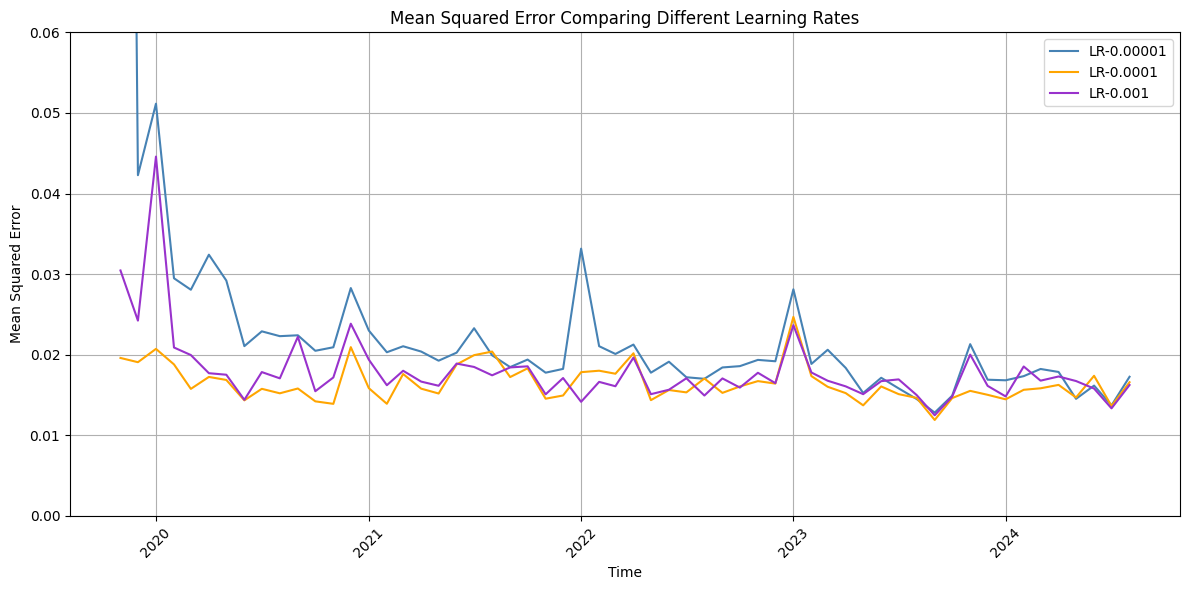

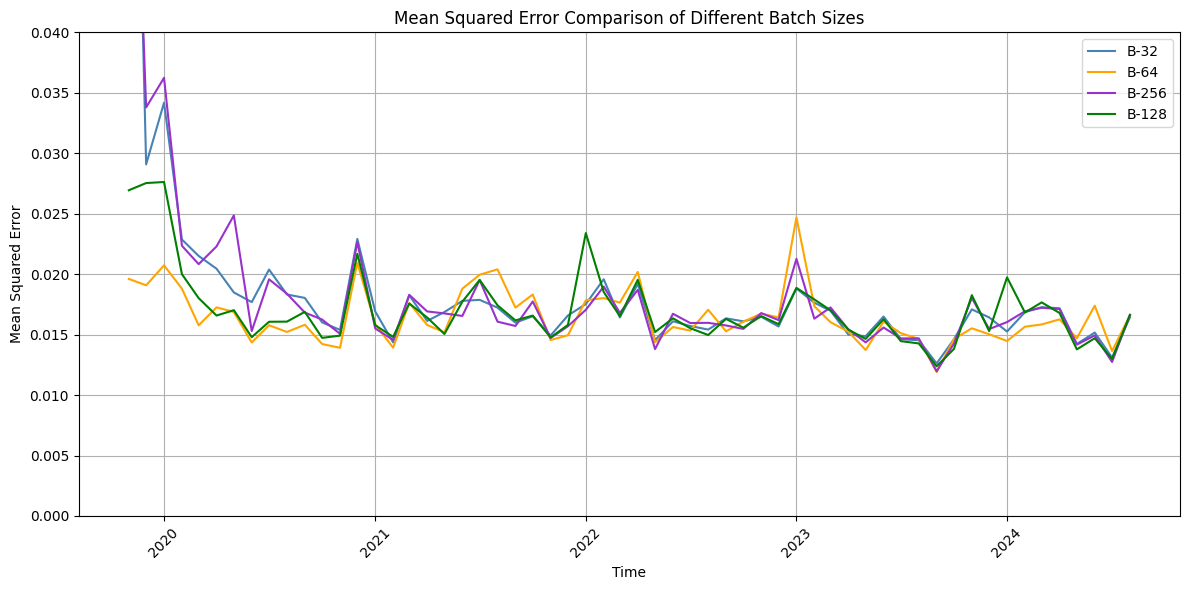

In [ ]:
# Calculate MSE and standard deviation per window for baseline and final predictions
mse_std_per_window = merged_df.groupby('DATE').apply(
    lambda x: pd.Series({
        'mse_mbstgnn': np.mean((x['y_true'] - x['y_pred_mbstgnn']) ** 2),
        'upper_mbstgnn': np.quantile((x['y_true'] - x['y_pred_mbstgnn']) ** 2, 0.75),
        'lower_mbstgnn': np.quantile((x['y_true'] - x['y_pred_mbstgnn']) ** 2, 0.25),
        'mse_l_00001': np.mean((x['y_true'] - x['y_pred_lr_00001']) ** 2),
        'upper_l_00001': np.quantile((x['y_true'] - x['y_pred_lr_00001']) ** 2, 0.75),
        'lower_l_00001': np.quantile((x['y_true'] - x['y_pred_lr_00001']) ** 2, 0.25),
        'mse_l_001': np.mean((x['y_true'] - x['y_pred_lr_001']) ** 2),
        'upper_l_001': np.quantile((x['y_true'] - x['y_pred_lr_001']) ** 2, 0.75),
        'lower_l_001': np.quantile((x['y_true'] - x['y_pred_lr_001']) ** 2, 0.25),
        'mse_b_32': np.mean((x['y_true'] - x['y_pred_b_32']) ** 2),
        'upper_b_32': np.quantile((x['y_true'] - x['y_pred_b_32']) ** 2, 0.75),
        'lower_b_32': np.quantile((x['y_true'] - x['y_pred_b_32']) ** 2, 0.25),
        'mse_b_256': np.mean((x['y_true'] - x['y_pred_b_256']) ** 2),
        'upper_b_256': np.quantile((x['y_true'] - x['y_pred_b_256']) ** 2, 0.75),
        'lower_b_256': np.quantile((x['y_true'] - x['y_pred_b_256']) ** 2, 0.25),
        'mse_b_128': np.mean((x['y_true'] - x['y_pred_b_128']) ** 2),
        'upper_b_128': np.quantile((x['y_true'] - x['y_pred_b_128']) ** 2, 0.75),
        'lower_b_128': np.quantile((x['y_true'] - x['y_pred_b_128']) ** 2, 0.25)

    })
).reset_index()

# Plot the MSE per window with standard deviation as shaded area
plt.figure(figsize=(12, 6))

plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_l_00001'], label='LR-0.00001', color='steelblue')
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn'], label='LR-0.0001', color='orange')
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_l_001'], label='LR-0.001', color='darkorchid')
plt.title('Mean Squared Error Comparing Different Learning Rates')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0,0.06)
plt.tight_layout()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_b_32'], label='B-32', color='steelblue')
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_mbstgnn'], label='B-64', color='orange')
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_b_256'], label='B-256', color='darkorchid')
plt.plot(mse_std_per_window['DATE'], mse_std_per_window['mse_b_128'], label='B-128', color='green')
plt.title('Mean Squared Error Comparison of Different Batch Sizes')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0,0.04)
plt.tight_layout()
plt.grid(True)
plt.show()


